## Introduction/Problem Statement
 
The problem I wanted to explore was ways in which to increase the overall customer experience. 

I wanted to choose a problem which directly affects the bottom-line of a company. There are two ways to do this: increasing revenues or decreasing costs. Now, it is very difficult to decrease costs in a market such as the airline industry where competition is sleep and price for labor and suppliers is fairly constant. One of the biggest differentiators in this space (as in most others) is customer service.

## Project Goals:
1. Pull tweets using Twitter API
2. Classify incoming tweets as negative or positive using sentiment analysis
3. Gain insights from data using Exploratory Data Analysis (EDA)
4. Create "Customer Improvement Proposal" 

## Data Collection Process

As in any data science project, getting reliable data to work with is perhaps one of the most challenging aspects of a project. My initial goal was to use the Twitter API so I can pull the most recent tweets and be able to complete a more relevant and up-to-date project. Unfortunately, Twitter’s API limits users to only pull tweets dating one week back. Given the timeframe to complete this project, I would simply not have enough data to conduct an accurate and thorough analysis. 
 
In order to be able to report something useful to a group of stakeholders, I narrowed my project scope to perform sentiment analysis on the airline industry. Thankfully, I was not the first one to think of this problem and was able to retrieve a Kaggle dataset containing airline tweets spanning a week long from February 2015.

The entire dataset can be seen here:
https://www.kaggle.com/crowdflower/twitter-airline-sentiment

## Let's Begin Some EDA

In [1]:
#import modules for some basic data cleaning
import numpy as np
import scipy 
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

#### Load in Kaggle Dataset

In [2]:
airline_tweets = pd.read_csv('../AneelProjectFolder/Tweets.csv')
airline_tweets.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [3]:
airline_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [4]:
#Based on the information above and amount of null values, I can go ahead and drop the 'airline_sentiment_gold', 'negativereason_gold', and
# 'tweet_cord' columns. Tweet_cord may be useful but there already happens to be the tweet_location and user_timezone
# columns which essentially are telling of the same information
del airline_tweets['airline_sentiment_gold']
del airline_tweets['negativereason_gold']
del airline_tweets['tweet_coord']

In [5]:
#Examining the shape of the dataset after deleting the above columns
airline_tweets.shape

(14640, 12)

Let's do some feature engineering to split the tweet_created column into date, time, and hour of day for further exploration in the near future

In [6]:
tweet_created = []
for x in airline_tweets.tweet_created:
    tweet_created.append(x[:19])

In [7]:
airline_tweets['tweet_created'] = pd.to_datetime(airline_tweets.tweet_created)
airline_tweets['tweet_created_date'] = airline_tweets.tweet_created.dt.date
airline_tweets['tweet_created_time'] = airline_tweets.tweet_created.dt.time
airline_tweets['tweet_created_hour'] = airline_tweets.tweet_created.dt.hour

In [8]:
airline_tweets.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,tweet_created_date,tweet_created_time,tweet_created_hour
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 19:35:52,NaN,Eastern Time (US & Canada),2015-02-24,19:35:52,19
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 19:15:59,NaN,Pacific Time (US & Canada),2015-02-24,19:15:59,19


#### Examining the range of the data

In [9]:
print (airline_tweets.tweet_created.min())
print (airline_tweets.tweet_created.max())

2015-02-17 07:36:05
2015-02-24 19:53:37


In [10]:
#Taking a look at all the columns post feature engineering
print(airline_tweets.columns)

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline', 'name',
       'retweet_count', 'text', 'tweet_created', 'tweet_location',
       'user_timezone', 'tweet_created_date', 'tweet_created_time',
       'tweet_created_hour'],
      dtype='object')


### Function Cleaning Up tweet_location column
Another aspect of my data cleaning involved writing a function to separate the city and state by a comma as key/value pairs in an empty dictionary

In [83]:
cities = airline_tweets.tweet_location
#print cities

def test_func(series):
    mapping_dictionary = {}
    
    for x in series:
        try:
            if np.isnan(x):
                mapping_dictionary[x] = x
        except:
            if ',' in x:
                my_info = x.split(',')
                mapping_dictionary[my_info[0]] = x
                mapping_dictionary[x] = x
            else:
                if x not in mapping_dictionary:
                    mapping_dictionary[x] = x
    
    return mapping_dictionary

y = test_func(cities)
print(y)
airline_tweets.tweet_location.map(y)

### Another function manually doing some more cleaning to tweet_location column

In [17]:
def noise(bs):
    if bs == 'USA, USA!':
        return np.nan
    elif bs == 'Washington DC, New York':
        return np.nan
    elif bs == 'Toronto,Montreal,L.A,NY':
        return np.nan
    elif bs == 'Global':
        return np.nan
    elif bs == 'BTR/DCA/IAD/MSY - etc':
        return np.nan
    elif bs == 'Does it really matter':
        return np.nan
    elif bs == 'Earth':
        return np.nan
    elif bs == 'Long Island - Arizona':
        return np.nan
    elif bs == 'Somewhere over the rainbow.':
        return np.nan
    elif bs == 'United States':
        return np.nan
    elif bs == 'On a beach':
        return np.nan
    elif bs == 'All Over The World':
        return np.nan
    elif bs == 'PA, NY & HI':
        return np.nan
    elif bs == 'Everywhere':
        return np.nan
    elif bs == 'Pursuit of Happiness':
        return np.nan
    elif bs == 'Philly, Chicago, MSP, Vegas':
        return np.nan
    elif bs == 'UK, USA. ':
        return 'London, UK'
    else:
        return bs

airline_tweets.tweet_location = airline_tweets.tweet_location.map(noise)

In [20]:
cleaned_loc = airline_tweets['tweet_location'].value_counts()
cleaned_loc.head(20)

New York, NY         815
Washington, D.C.     279
Boston, MA           251
San Francisco, CA    228
Chicago, IL          185
Los Angeles, CA      181
Dallas, TX           118
Austin, TX            85
San Diego, CA         75
Houston, TX           71
Seattle, WA           55
Las Vegas, NV         51
Denver, CO            51
Philadelphia, PA      51
Nashville, TN         49
Texas, USA            47
Atlanta, GA           36
London, England       35
New Jersey, USA       31
Raleigh, NC           30
Name: tweet_location, dtype: int64

In [21]:
cleaned_loc.map(lambda x: x if x > 15 else np.nan).dropna().head(2)

New York, NY        815.0
Washington, D.C.    279.0
Name: tweet_location, dtype: float64

### Manually mapping tweet_locations get in City, State or State, Country format

In [18]:
y['New York'] = 'New York, NY'
y['new york city'] = 'New York, NY'
y['new york, baby'] = 'New York, NY'
y['Rochester, NY'] = 'New York, NY'
y['bonkers in Yonkers'] = 'New York, NY'
y['New York City'] = 'New York, NY'
y['New York City, NY'] = 'New York, NY'
y['NYC, NY'] = 'New York, NY'
y['nyc'] = 'New York, NY'
y['NY, NY'] = 'New York, NY'
y['New York, New York'] = 'New York, NY'
y['NYCATL'] = 'New York, NY'
y['Long Island, NY'] = 'New York, NY'
y['Long Island, New York'] = 'New York, NY'
y['Brooklyn, NY'] = 'New York, NY'
y['BK'] = 'New York, NY'
y['Buffalo, NY'] = 'New York, NY'
y['ÜT: 40.96513,-73.872957'] = 'New York, NY'
y['Logan International Airport'] = 'Boston, MA'
y['DC'] = 'Washington, D.C.'
y['washington, dc'] = 'Washington, D.C.'
y['Washington, DC'] = 'Washington, D.C.'
y['Washington D.C.'] = 'Washington, D.C.'
y['Pekin'] = 'Pekin, IL'
y['CT, USA'] = 'Connecticut, USA'
y['Belle MO'] = 'Belle, MO'
y['Austin, Texas'] = 'Austin, TX'
y['Dallas, Texas'] = 'Dallas, TX'
y['Worldwide, based in Dallas, TX'] = 'Dallas, TX'
y['DFW, TX'] = 'Dallas, TX'
y['McKinney TX'] = 'McKinney, TX'
y['Houston, Texas'] = 'Houston, TX'
y['san diego, CA'] = 'San Diego, CA'
y['Los Angeles, California'] = 'Los Angeles, CA'
y['Southern California, USA'] = 'Los Angeles, CA'
y['Oakland, CA'] = 'San Francisco, CA'
y['Bay Area, CA'] = 'San Francisco, CA'
y['San Francisco Bay Area, USA'] = 'San Francisco, CA'
y['San Francisco, California'] = 'San Francisco, CA'
y['Irvine, Ca'] = 'Irvine, CA'
y['Colorado'] = 'Colorado, USA'
y['Rhode Island'] = 'Rhode Island, USA'
y['Ohio'] = 'Ohio, USA'
y['Columbus, Ohio'] = 'Columbus, OH'
y['columbus, oh'] = 'Colombus, OH'
y['Cleveland, Ohio'] = 'Cleveland, OH'
y['Massachusetts'] = 'Massachusetts, USA'
y['Plano, Texas'] = 'Plano, TX'
y['Portland, Maine'] = 'Portland, ME'
y['Pennsylvania'] = 'Pennsylvania, USA'
y['Northern Virginia'] = 'Virginia, USA'
y['Mexico City, Mexico'] = 'Mexico City, MX'
y['Ottawa, Canada'] = 'Canada'
y['Englewood, Florida'] = 'Englewood, FL'
y['Kansas City, MO USA'] = 'Kansas City, MO'
y['Connecticut'] = 'Connecticut, USA'

airline_tweets.tweet_location = airline_tweets.tweet_location.map(y)

In [19]:
airline_tweets['tweet_location'].value_counts().head(30)

New York, NY         815
Washington, D.C.     279
Boston, MA           251
San Francisco, CA    228
Chicago, IL          185
Los Angeles, CA      181
Dallas, TX           118
Austin, TX            85
San Diego, CA         75
Houston, TX           71
Seattle, WA           55
Las Vegas, NV         51
Denver, CO            51
Philadelphia, PA      51
Nashville, TN         49
Texas, USA            47
Atlanta, GA           36
London, England       35
New Jersey, USA       31
Raleigh, NC           30
Canada                30
Cleveland, OH         30
Columbus, OH          28
Virginia, USA         28
Memphis, TN           28
Arlington, VA         27
Connecticut, USA      25
London, UK            24
Pittsburgh, PA        23
Asheville, NC         22
Name: tweet_location, dtype: int64

### Now that we've done a majority of the cleaning, let's do some subsetting to draw more inferences about our data 

In [22]:
colors=sns.color_palette("hls", 10) #selecting a colorful palette from the seaborn library

## Where Are Our Tweets Coming From?

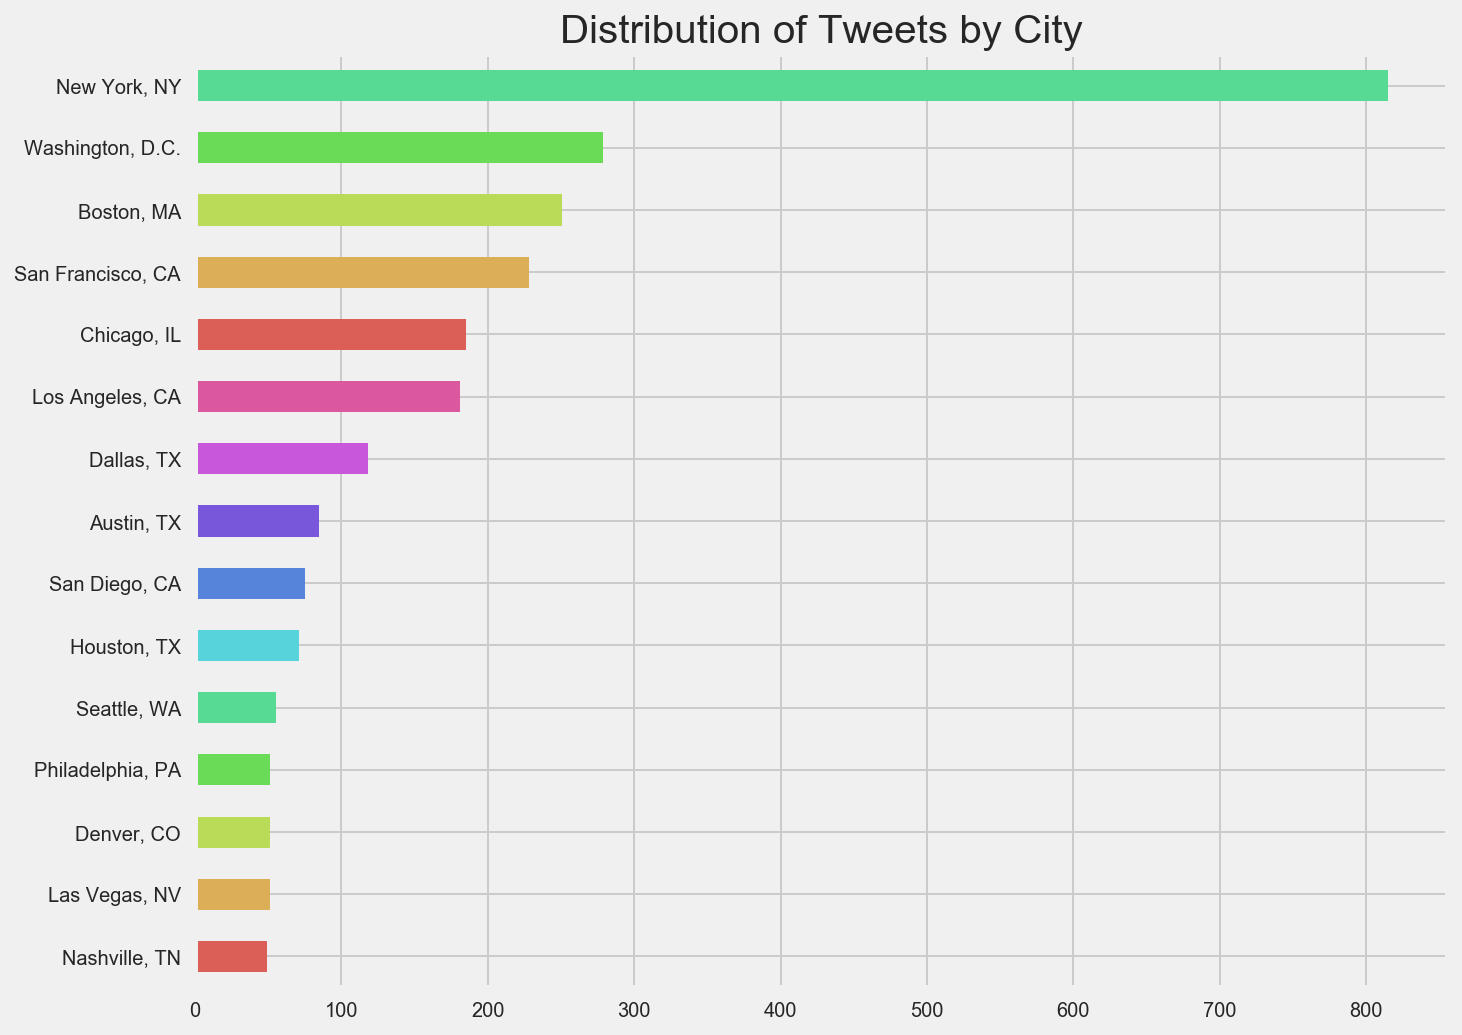

In [25]:
loc = pd.DataFrame(loc) 
loc = airline_tweets['tweet_location'].value_counts().map(lambda x: x if x > 15 else np.nan).dropna().head(15)
loc.sort_values(ascending=True).plot(kind='barh',color=colors,title='Distribution of Tweets by City', 
                                      figsize=(10, 8))

## Comparing results above with user_timezone column

In [26]:
airline_tweets.user_timezone.value_counts().head(10)

Eastern Time (US & Canada)     3744
Central Time (US & Canada)     1931
Pacific Time (US & Canada)     1208
Quito                           738
Atlantic Time (Canada)          497
Mountain Time (US & Canada)     369
Arizona                         229
London                          195
Alaska                          108
Sydney                          107
Name: user_timezone, dtype: int64

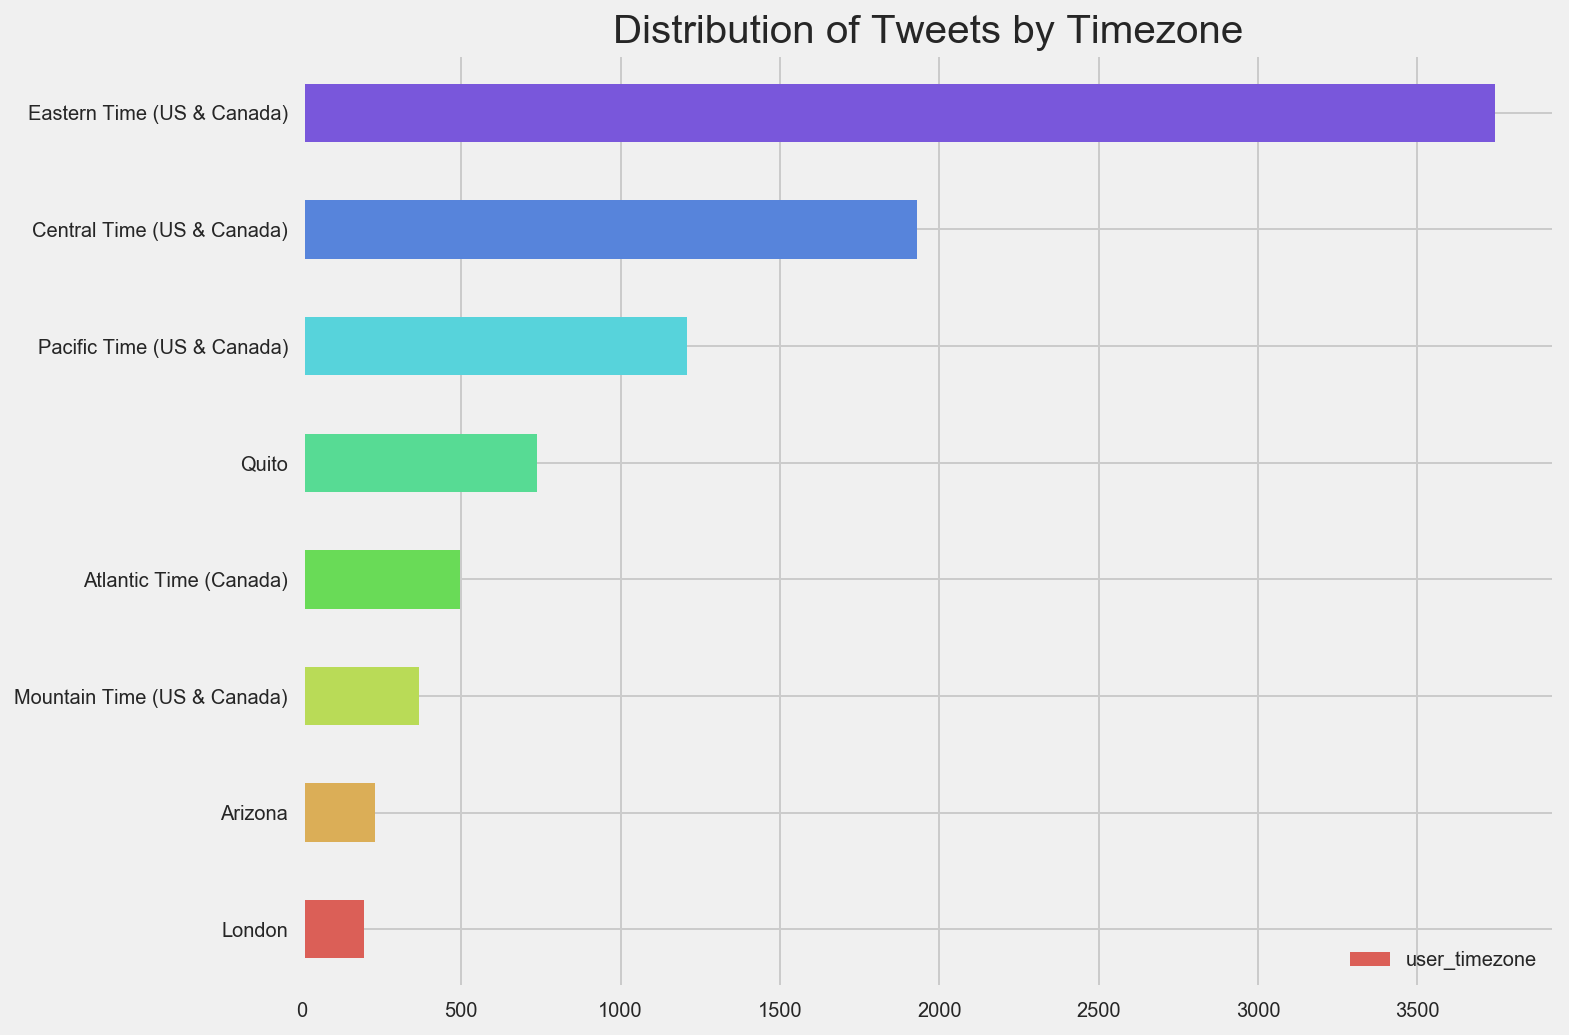

In [27]:
loc = airline_tweets['user_timezone'].value_counts().map(lambda x: x if x > 100 else np.nan).dropna().head(8)
loc = pd.DataFrame(loc)
loc.sort_values(by='user_timezone',ascending=True).plot(kind='barh',color=colors,title='Distribution of Tweets by Timezone', 
                                      figsize=(10, 8))

The results are pretty consistent. The majority of tweets are coming from major cities such as NY, D.C., Boston, SF, Chicago and LA. This is probably because these cities are international hubs and many connecting flights go through here

## Distribution of Tweets by Sentiment

In [28]:
mood_counts = airline_tweets['airline_sentiment'].value_counts()
mood_counts

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

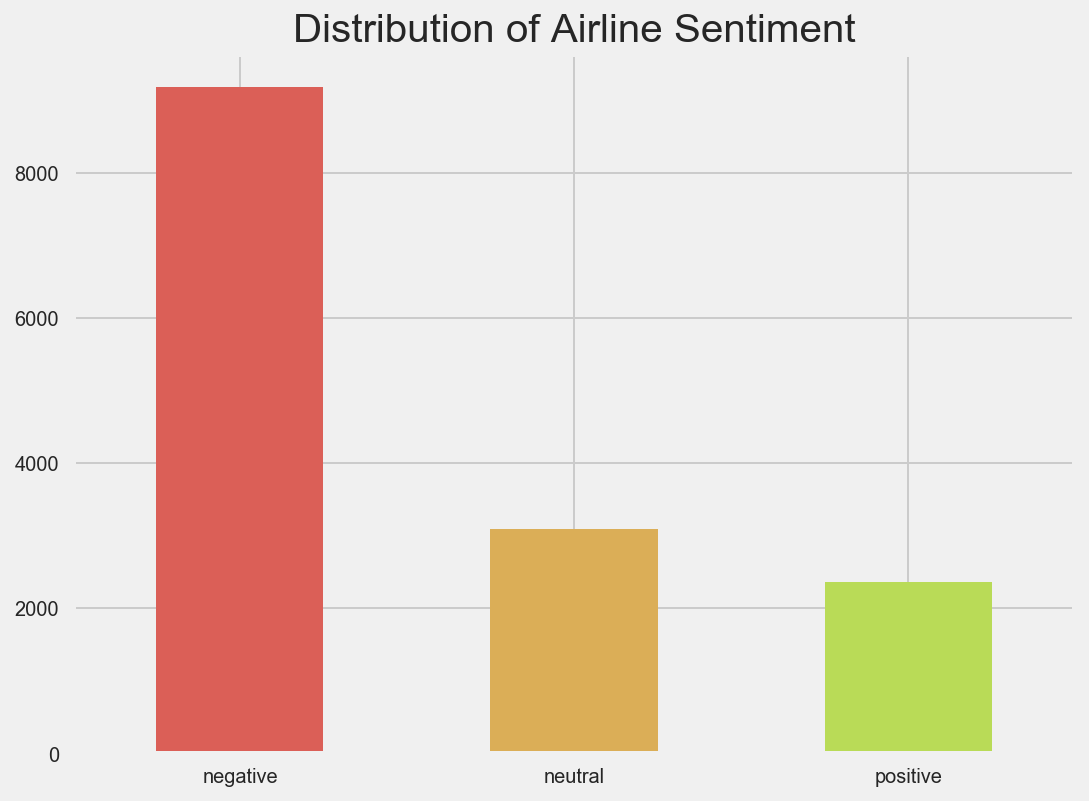

In [29]:
pd.Series(airline_tweets["airline_sentiment"]).value_counts().plot(kind = "bar",color=colors,
                                                                   figsize=(8,6),rot=0, title = "Distribution of Airline Sentiment")

## Distribution of Tweets by Airline

In [30]:
airline_tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

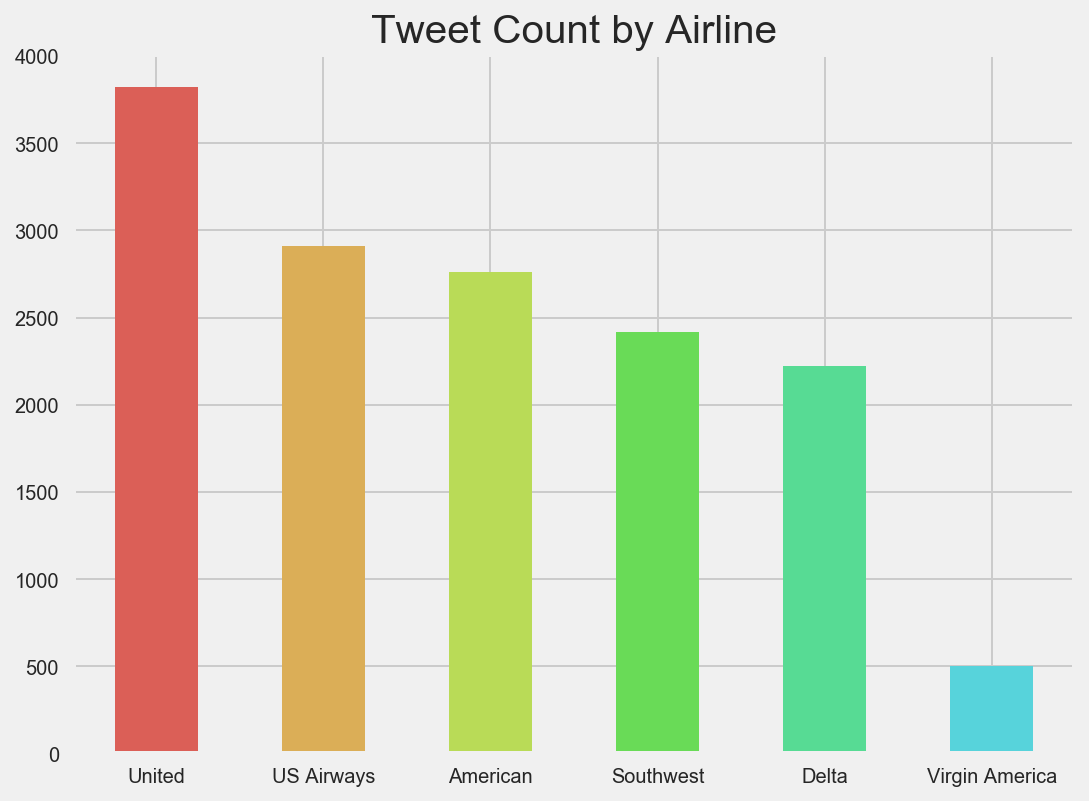

In [31]:
pd.Series(airline_tweets["airline"]).value_counts().plot(kind = "bar", color=colors,
                                                         figsize=(8,6),fontsize=10,rot=0,title="Tweet Count by Airline")

The data is not very normally distributed in both charts. There are some airlines which have far more tweets than others and it seems as if users are more likely to tweet with negative sentiment when talking about their overall experience.

United has nearly 1000 more tweets than US Airways and the next 4 airlines are all within 700 tweets. Virgin has the least with about 500 tweets. 

## Creating Masks to Subset By Airline 

In [32]:
virgin_mask = airline_tweets[airline_tweets['airline'] == "Virgin America"]
united_mask = airline_tweets[airline_tweets['airline'] == "United"]
southwest_mask = airline_tweets[airline_tweets['airline'] == "Southwest"]
delta_mask = airline_tweets[airline_tweets['airline'] == "Delta"]
us_airways_mask = airline_tweets[airline_tweets['airline'] == "US Airways"]
american_mask = airline_tweets[airline_tweets['airline'] == "American"]

### Virgin America Tweets by Location

In [33]:
virgin_mask['tweet_location'].value_counts().head(5)

San Francisco, CA    41
New York, NY         35
Los Angeles, CA      29
Dallas, TX           14
Las Vegas, NV        11
Name: tweet_location, dtype: int64

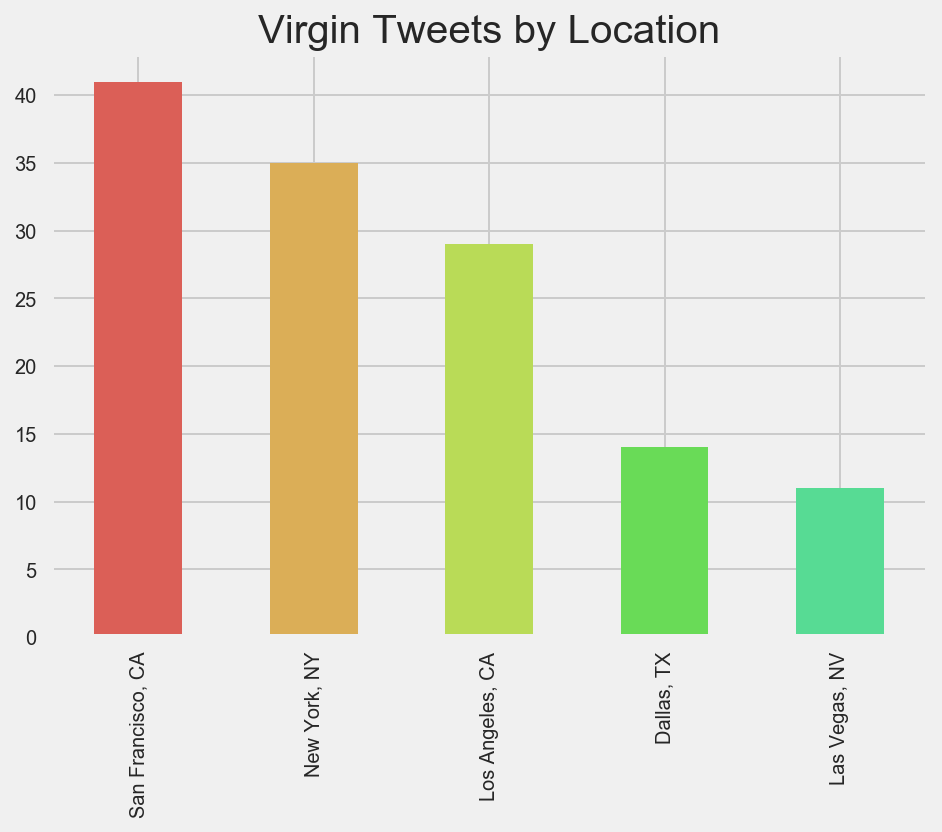

In [34]:
virgin_mask['tweet_location'].value_counts().head(5).plot(kind='bar',color=colors, title='Virgin Tweets by Location',
                                                          figsize=(7,5))

### United Tweets by Location

In [35]:
united_mask['tweet_location'].value_counts().head(5)

New York, NY         175
San Francisco, CA    108
Chicago, IL           76
Washington, D.C.      47
Houston, TX           46
Name: tweet_location, dtype: int64

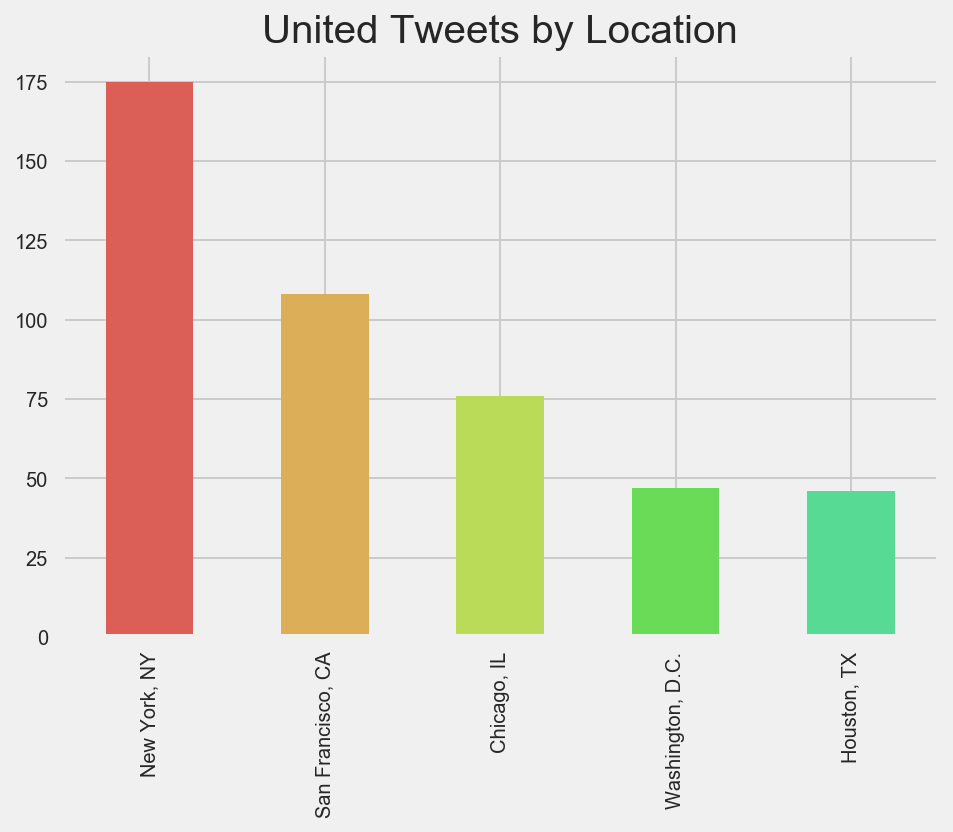

In [36]:
united_mask['tweet_location'].value_counts().head(5).plot(kind='bar',color=colors, title='United Tweets by Location',
                                                          figsize=(7,5))

### Southwest Tweets by Location

In [37]:
southwest_mask['tweet_location'].value_counts().head(5)

New York, NY       44
Chicago, IL        44
Nashville, TN      39
Austin, TX         28
Los Angeles, CA    26
Name: tweet_location, dtype: int64

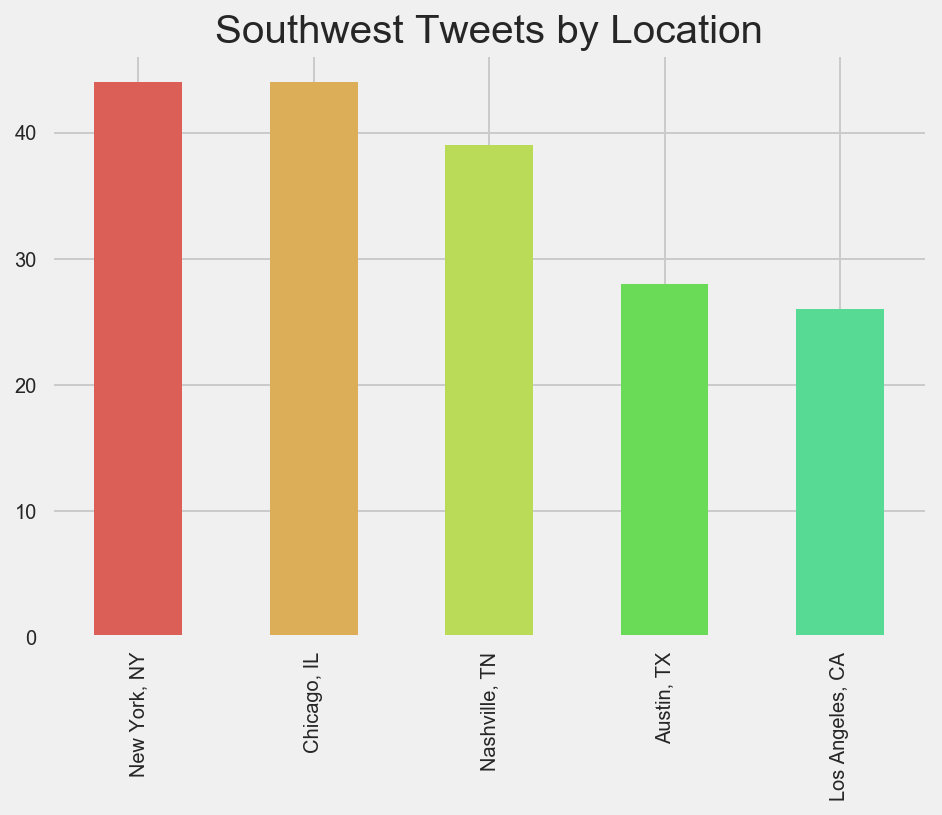

In [38]:
southwest_mask['tweet_location'].value_counts().head(5).plot(kind='bar',color=colors, title='Southwest Tweets by Location',
                                                          figsize=(7,5))

### Delta Tweets by Location

In [39]:
delta_mask['tweet_location'].value_counts().head(5)

New York, NY         311
Boston, MA           117
Washington, D.C.      37
Los Angeles, CA       21
San Francisco, CA     19
Name: tweet_location, dtype: int64

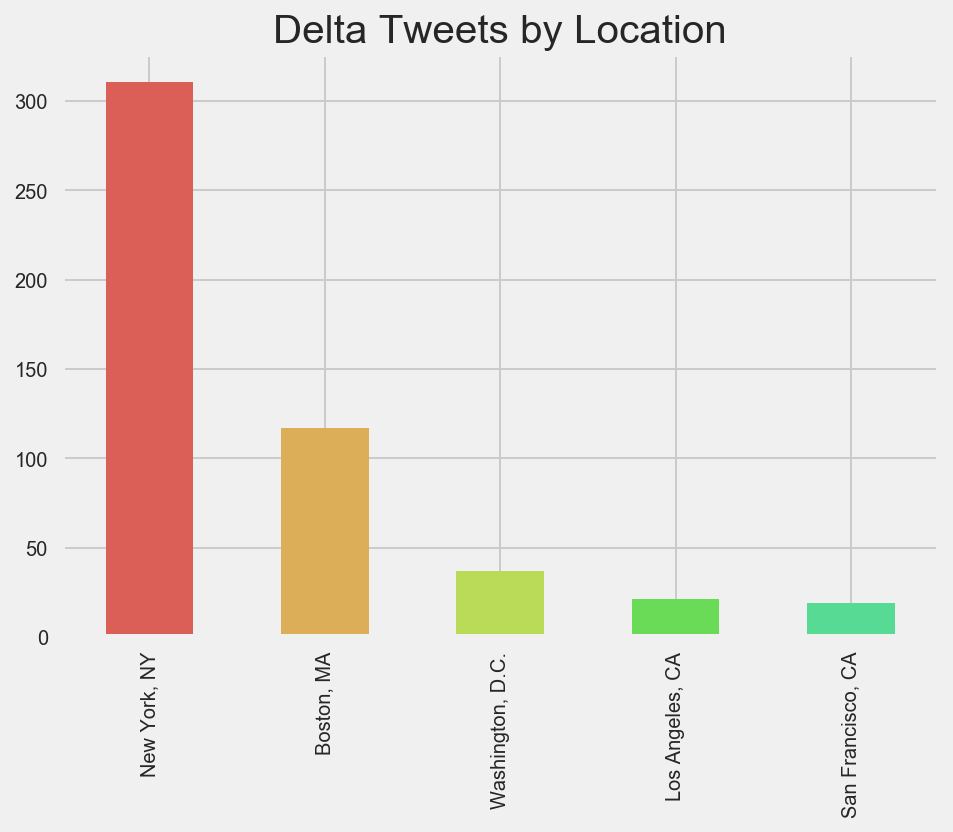

In [40]:
delta_mask['tweet_location'].value_counts().head(5).plot(kind='bar',color=colors, title='Delta Tweets by Location',
                                                          figsize=(7,5))

### U.S. Airways Tweets By Location

In [41]:
us_airways_mask['tweet_location'].value_counts().head(5)

Washington, D.C.    121
New York, NY         96
Boston, MA           46
Philadelphia, PA     29
Asheville, NC        22
Name: tweet_location, dtype: int64

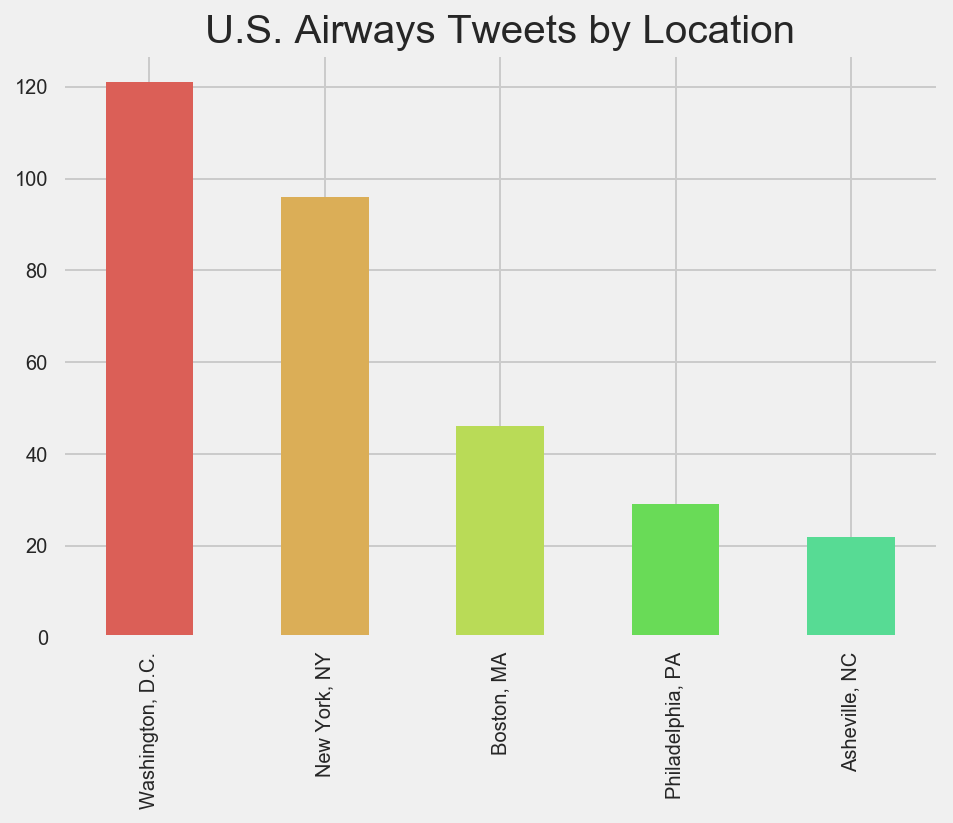

In [42]:
us_airways_mask['tweet_location'].value_counts().head(5).plot(kind='bar',color=colors, title='U.S. Airways Tweets by Location',
                                                          figsize=(7,5))

### American Tweets By Location

In [43]:
american_mask['tweet_location'].value_counts().head(5)

New York, NY        154
Los Angeles, CA      59
Dallas, TX           56
Chicago, IL          46
Washington, D.C.     40
Name: tweet_location, dtype: int64

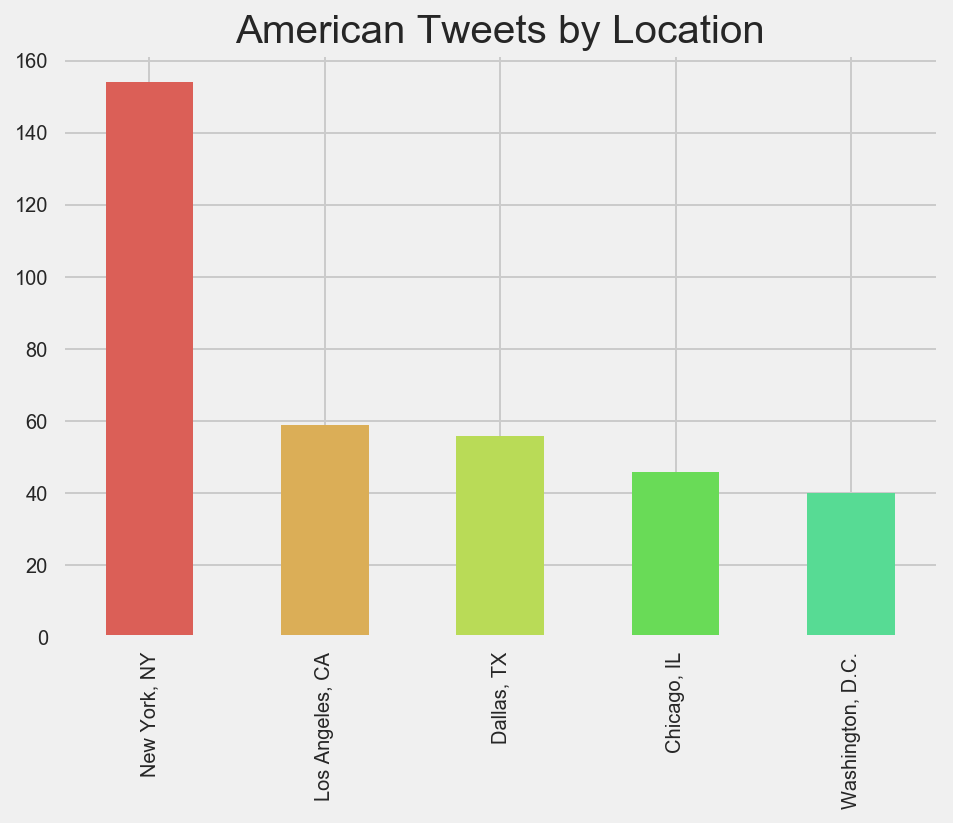

In [44]:
american_mask['tweet_location'].value_counts().head(5).plot(kind='bar',color=colors, title='American Tweets by Location',
                                                          figsize=(7,5))

## Examining Sentiment Across All Airlines

In [45]:
air_sen = pd.crosstab(airline_tweets.airline, airline_tweets.airline_sentiment)
air_sen

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


In [46]:
percentage = air_sen.apply(lambda a: a / a.sum() * 100, axis=1)
percentage

airline_sentiment,negative,neutral,positive
airline,,,
American,71.040232,16.781443,12.178325
Delta,42.979298,32.538254,24.482448
Southwest,49.008264,27.438017,23.553719
US Airways,77.686234,13.079300,9.234466
United,68.890633,18.236525,12.872841
Virgin America,35.912698,33.928571,30.158730


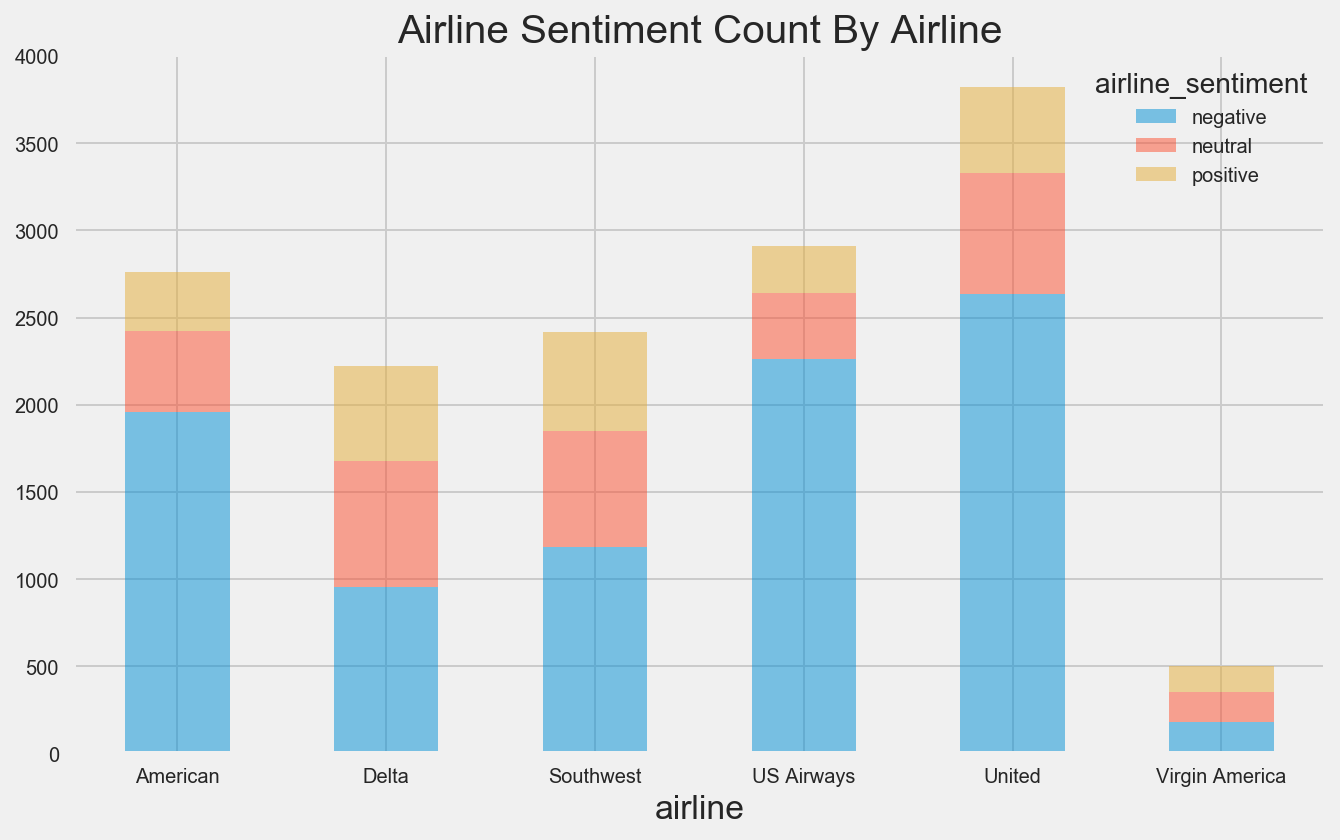

In [47]:
pd.crosstab(index = airline_tweets["airline"],columns = airline_tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),
                                                                              alpha=0.5,rot=0,stacked=True,title="Airline Sentiment Count By Airline")

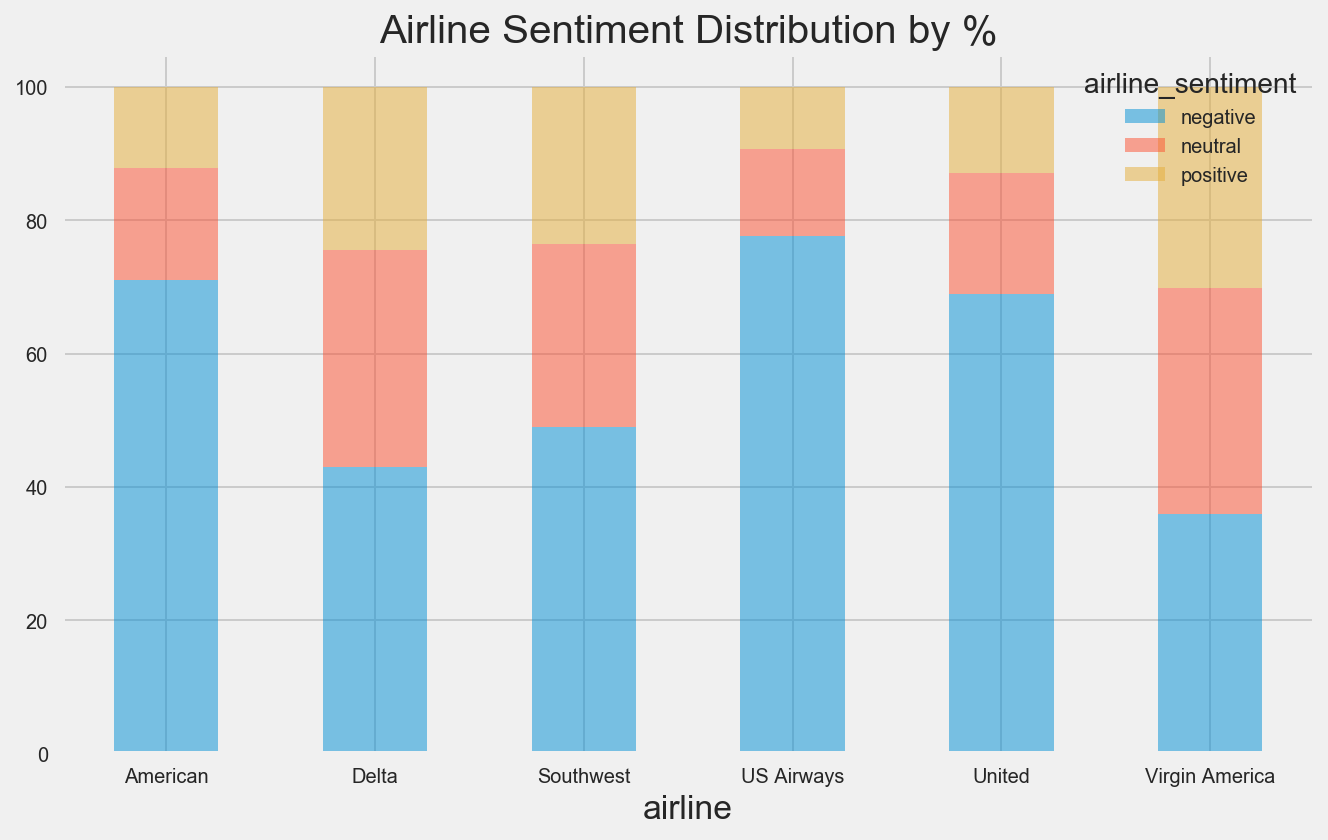

In [48]:
percentage.plot(kind='bar',figsize=(10, 6),alpha=0.5,
                rot=0,stacked=True,title="Airline Sentiment Distribution by %")

The first graph is taking a look at the sentiment by overall raw count while the one after shows the distribition of sentiment after normalizing by proportion. 

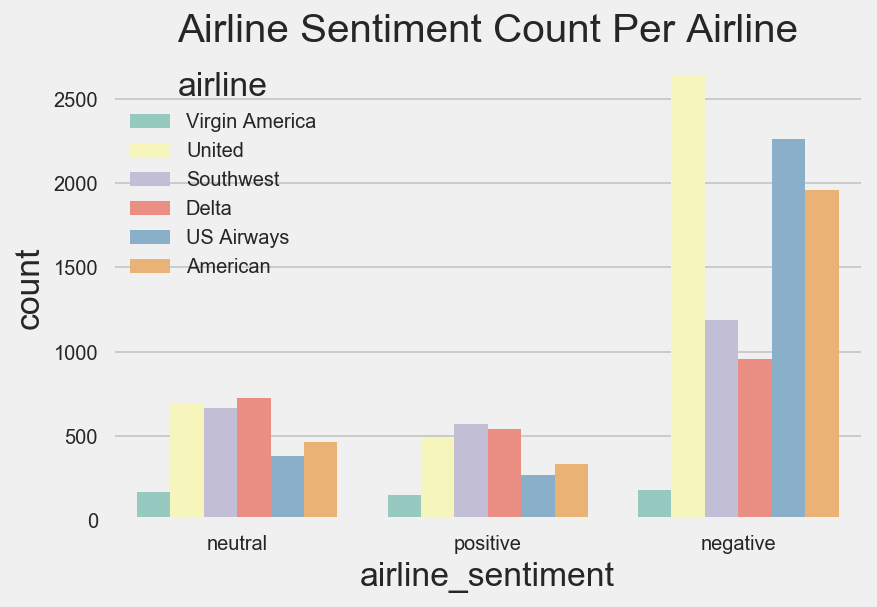

In [49]:
g = sns.countplot(x="airline_sentiment", data=airline_tweets, hue='airline',palette="Set3")

g.axes.set_title("Airline Sentiment Count Per Airline")

## Subsetting Sentiment by Date

In [50]:
date_sen = pd.crosstab(airline_tweets.tweet_created_date, airline_tweets.airline_sentiment)
date_sen

airline_sentiment,negative,neutral,positive
tweet_created_date,,,
2015-02-17,552,220,181
2015-02-18,827,304,285
2015-02-19,666,346,286
2015-02-20,849,383,280
2015-02-21,901,272,245
2015-02-22,1744,367,281
2015-02-23,2346,711,458
2015-02-24,1293,496,347


In [51]:
perc_date_sen = date_sen.apply(lambda a: a / a.sum() * 100, axis=1)
perc_date_sen

airline_sentiment,negative,neutral,positive
tweet_created_date,,,
2015-02-17,57.922350,23.084995,18.992655
2015-02-18,58.403955,21.468927,20.127119
2015-02-19,51.309707,26.656394,22.033898
2015-02-20,56.150794,25.330688,18.518519
2015-02-21,63.540197,19.181946,17.277856
2015-02-22,72.909699,15.342809,11.747492
2015-02-23,66.742532,20.227596,13.029872
2015-02-24,60.533708,23.220974,16.245318


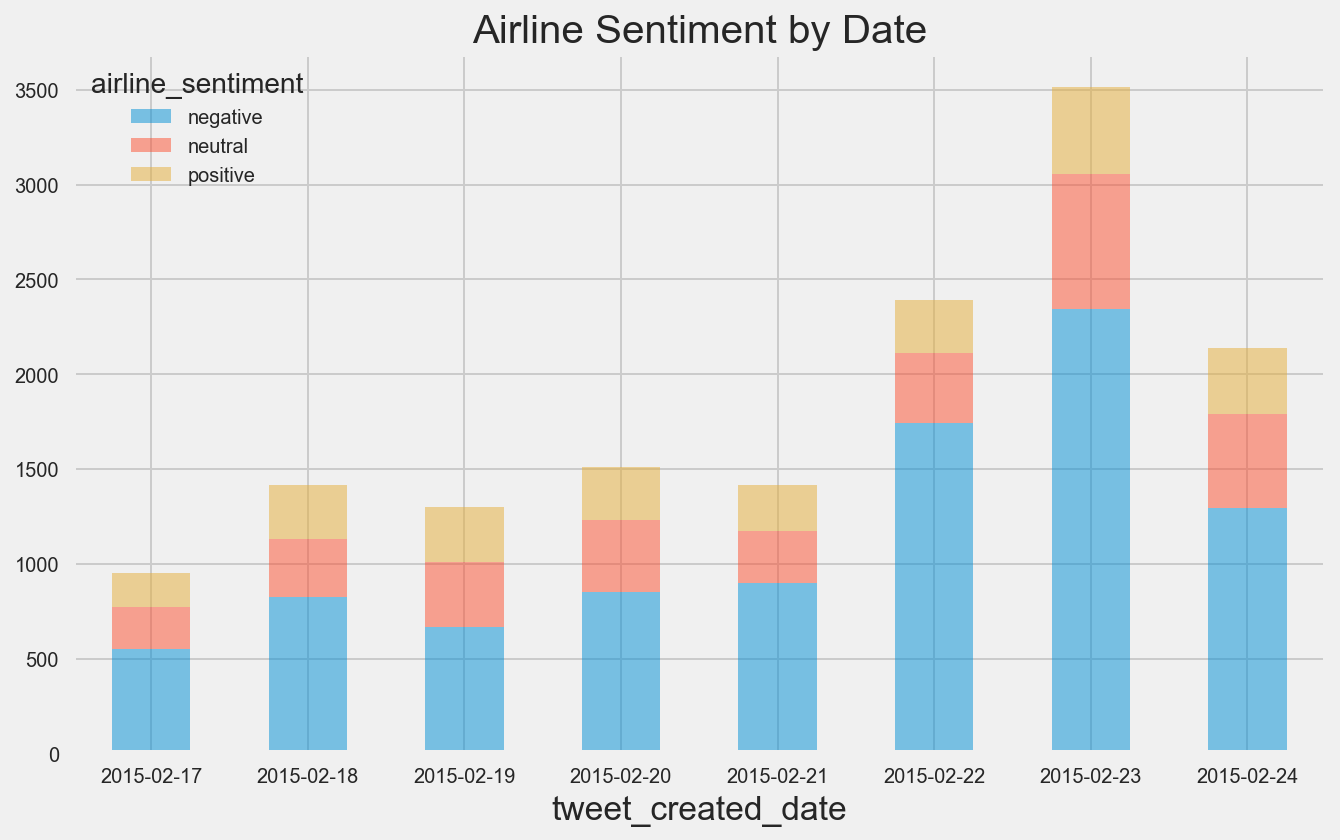

In [52]:
pd.crosstab(index = airline_tweets["tweet_created_date"],columns = airline_tweets["airline_sentiment"]).plot(kind='bar',
                                                                                         figsize=(10,6),alpha=0.5,rot=0,stacked=True,
                                                                                        title="Airline Sentiment by Date")

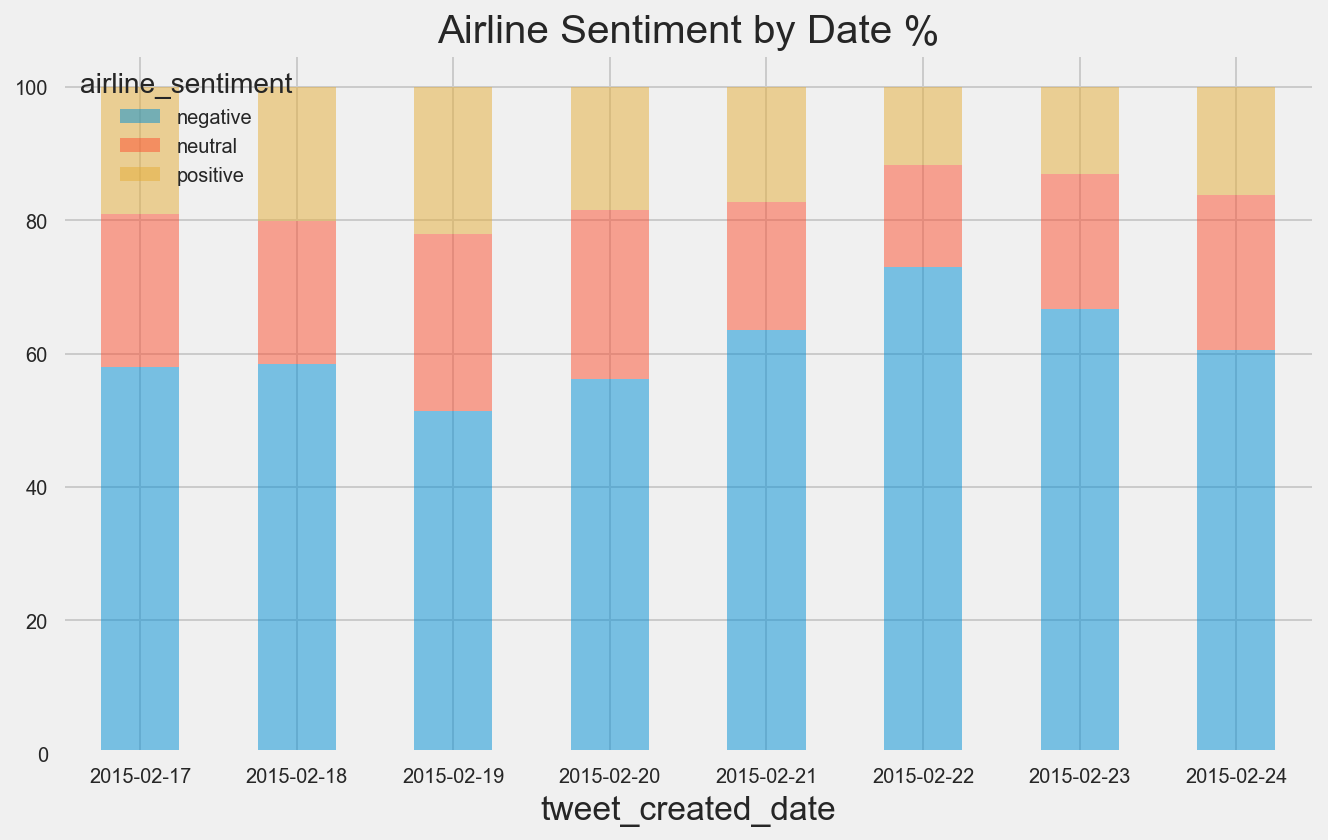

In [53]:
perc_date_sen.plot(kind='bar',figsize=(10,6),alpha=0.5,
                   rot=0,stacked=True,title="Airline Sentiment by Date %")

## Subsetting by Airline and Date

In [54]:
df = airline_tweets.groupby(['tweet_created_date','airline'])
df = df.airline_sentiment.value_counts()
df.unstack()

airline_sentiment                  negative  neutral  positive
tweet_created_date airline                                    
2015-02-17         Delta               51.0     63.0      47.0
                   Southwest          162.0     69.0      56.0
                   US Airways         156.0     22.0      33.0
                   United             173.0     50.0      29.0
                   Virgin America      10.0     16.0      16.0
2015-02-18         Delta              127.0     84.0      78.0
                   Southwest          143.0     96.0      90.0
                   US Airways         259.0     29.0      44.0
                   United             281.0     74.0      53.0
                   Virgin America      17.0     21.0      20.0
2015-02-19         American             1.0      NaN       1.0
                   Delta              127.0     68.0      74.0
                   Southwest          103.0    102.0      86.0
                   US Airways         189.0     58.0      34.0
                   United             224.0     97.0      71.0
                   Virgin America      22.0     21.0      20.0
2015-02-20         American             1.0      NaN       NaN
                   Delta              108.0     97.0      78.0
                   Southwest          139.0     98.0      73.0
                   US Airways         234.0     50.0      34.0
                   United             347.0    104.0      78.0
                   Virgin America      20.0     34.0      17.0
2015-02-21         American             1.0      NaN       NaN
                   Delta               91.0     78.0      55.0
                   Southwest          219.0     77.0      64.0
                   US Airways         224.0     31.0      26.0
                   United             333.0     72.0      72.0
                   Virgin America      33.0     14.0      28.0
2015-02-22         American           316.0     46.0      42.0
                   Delta              221.0     82.0      83.0
                   Southwest          143.0     52.0      53.0
                   US Airways         536.0     58.0      28.0
                   United             494.0    109.0      63.0
                   Virgin America      34.0     20.0      12.0
2015-02-23         American          1071.0    214.0     144.0
                   Delta              160.0    181.0      83.0
                   Southwest          151.0    107.0      94.0
                   US Airways         431.0     76.0      46.0
                   United             503.0    103.0      71.0
                   Virgin America      30.0     30.0      20.0
2015-02-24         American           570.0    203.0     149.0
                   Delta               70.0     70.0      46.0
                   Southwest          126.0     63.0      54.0
                   US Airways         234.0     57.0      24.0
                   United             278.0     88.0      55.0
                   Virgin America      15.0     15.0      19.0

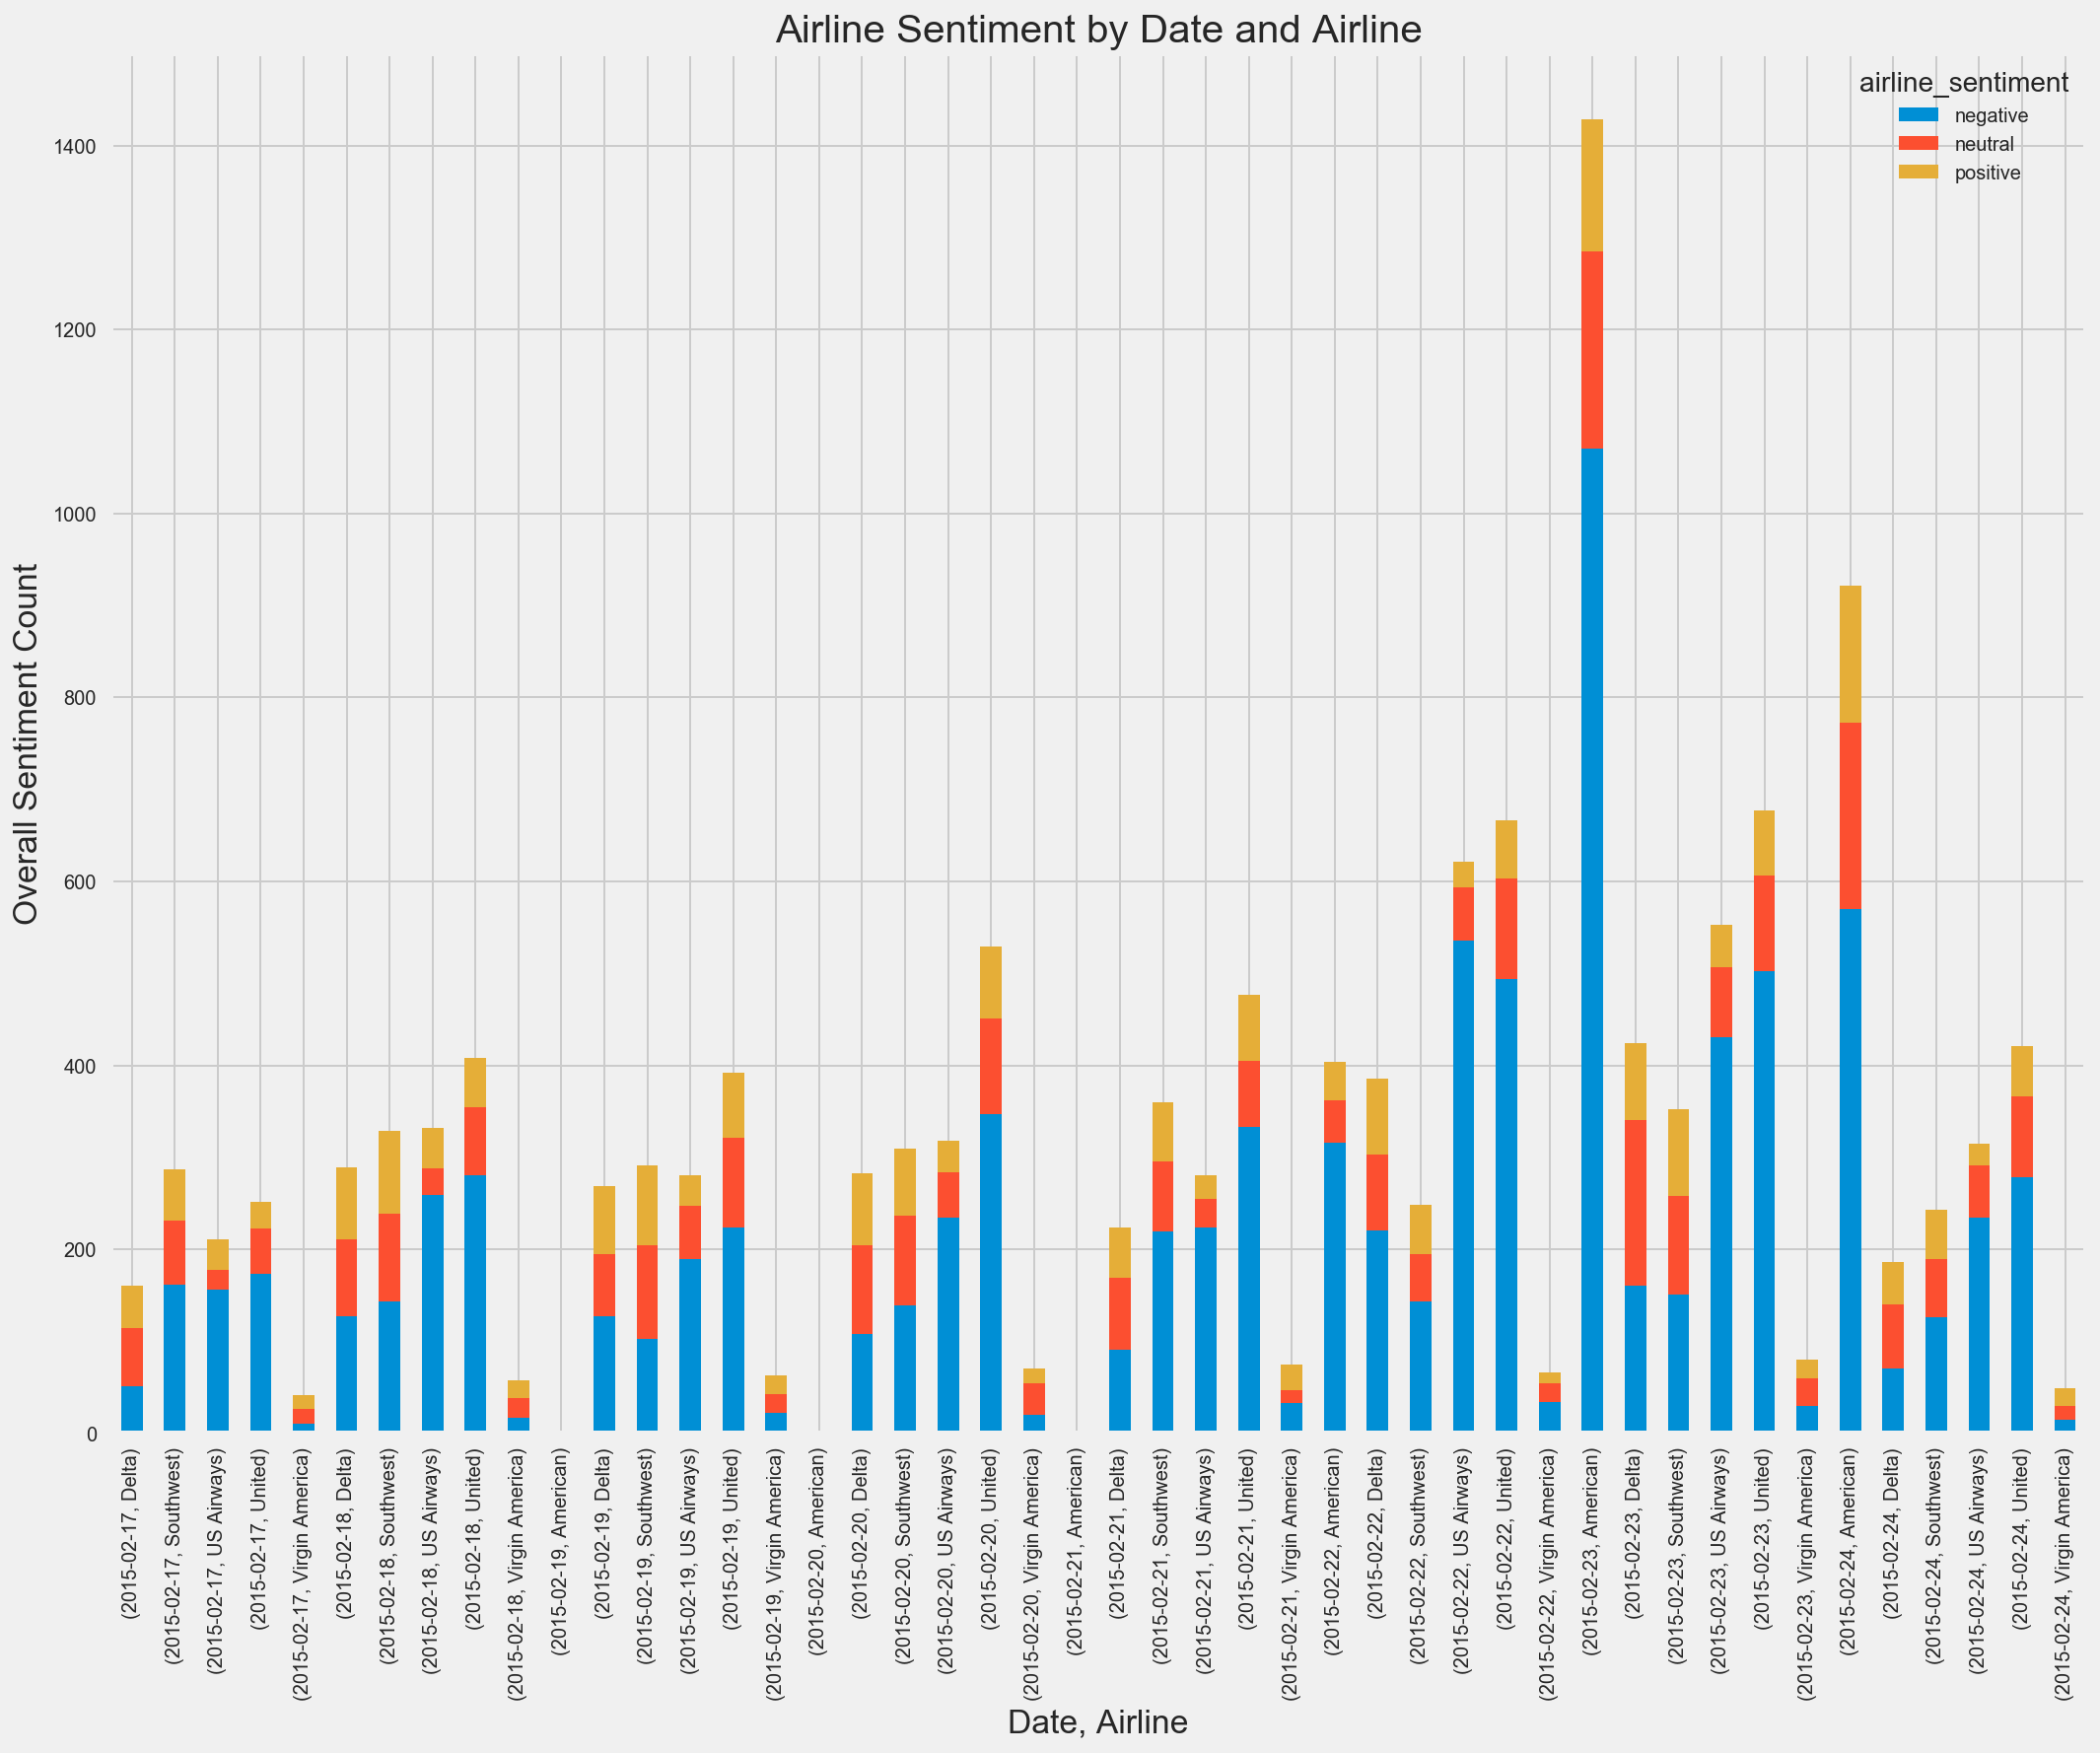

In [55]:
my_plot = df.unstack().plot(kind='bar',stacked=True,figsize=(16, 12),title="Airline Sentiment by Date and Airline")
my_plot.set_xlabel("Date, Airline")
my_plot.set_ylabel("Overall Sentiment Count")

# Time For Some Modeling

In [57]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

%matplotlib inline

sns.set_style("darkgrid")

In [58]:
# Import tweets dataset
tweets = pd.read_csv('../AneelProjectFolder/Tweets.csv',encoding="utf-8")

Before I even began thinking about which model to use, I needed to remove neutral tweets since they provided the least amount of insight given what I was trying to accomplish. In this instance, the goal was to classify tweets between positive and negative. Having said that, given that this was a typical classification problem, using Logistic Regression made the most sense.
 
The reason I chose to do it this way is because there were not a ton of data points and it would be easier to pick up noise on the extremes. The main issue with this model is that it would not categorize neutral tweets and would get grouped with either positive or negative. One way to address this issue would be to turn this into a multi-label classification model  so each tweet would be identified properly.

In [59]:
# remove all neutral tweets
tweets = tweets[tweets['airline_sentiment'] != 'neutral']

In [60]:
#Examining the shape after removing neutral tweets from the DataFrame
tweets.shape

(11541, 15)

In [61]:
tweets.airline_sentiment.value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

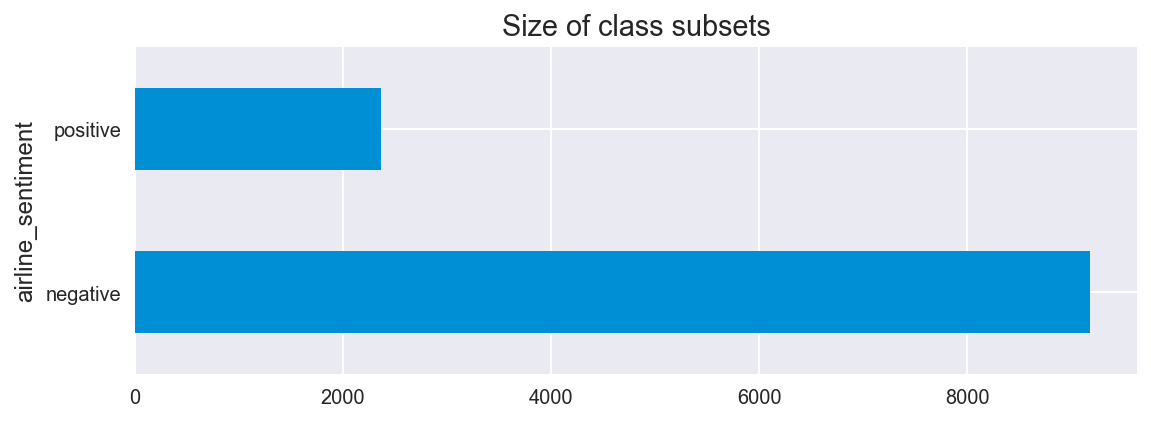

In [62]:
tweets.groupby("airline_sentiment").size().plot(kind="barh", title="Size of class subsets", figsize=(8, 3))

In [63]:
X = tweets['text']
y = tweets['airline_sentiment'].map(lambda x: 1 if x == 'positive' else 0)

In [64]:
# Preprocess our text data to Tfidf
tfv = TfidfVectorizer(lowercase=True, strip_accents='unicode')
X = tfv.fit_transform(tweets['text'])

# Setup logistic regression (or try another classification method here)
estimator = LogisticRegression()
estimator.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

accuracy [ 0.89616811  0.90852905  0.91223733  0.89245983  0.90594059  0.90210657
  0.8983891   0.89591078  0.9070632   0.89591078] 

mean of scores = 0.901471532934 

ConfusionMatrix 
   |    0    1 |
--+-----------+
0 |<6378>  36 |
1 |  969 <696>|
--+-----------+
(row = reference; col = test)

Sensitivity 
 0.418018018018


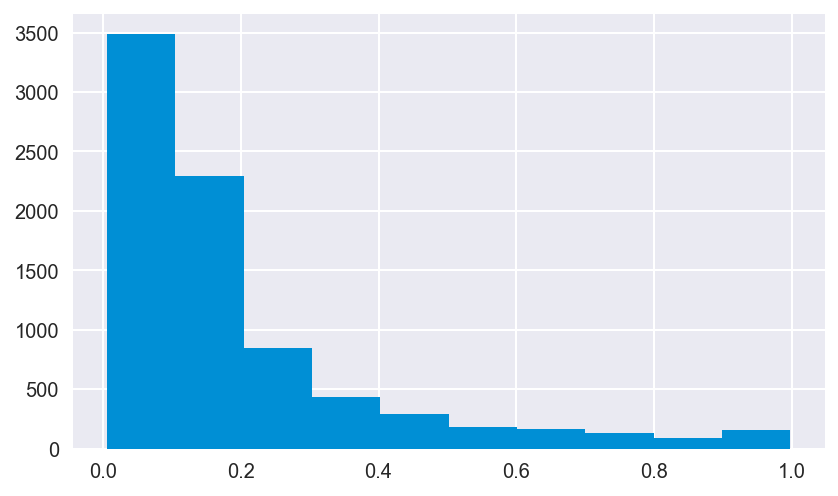

accuracy score = 0.875603416264


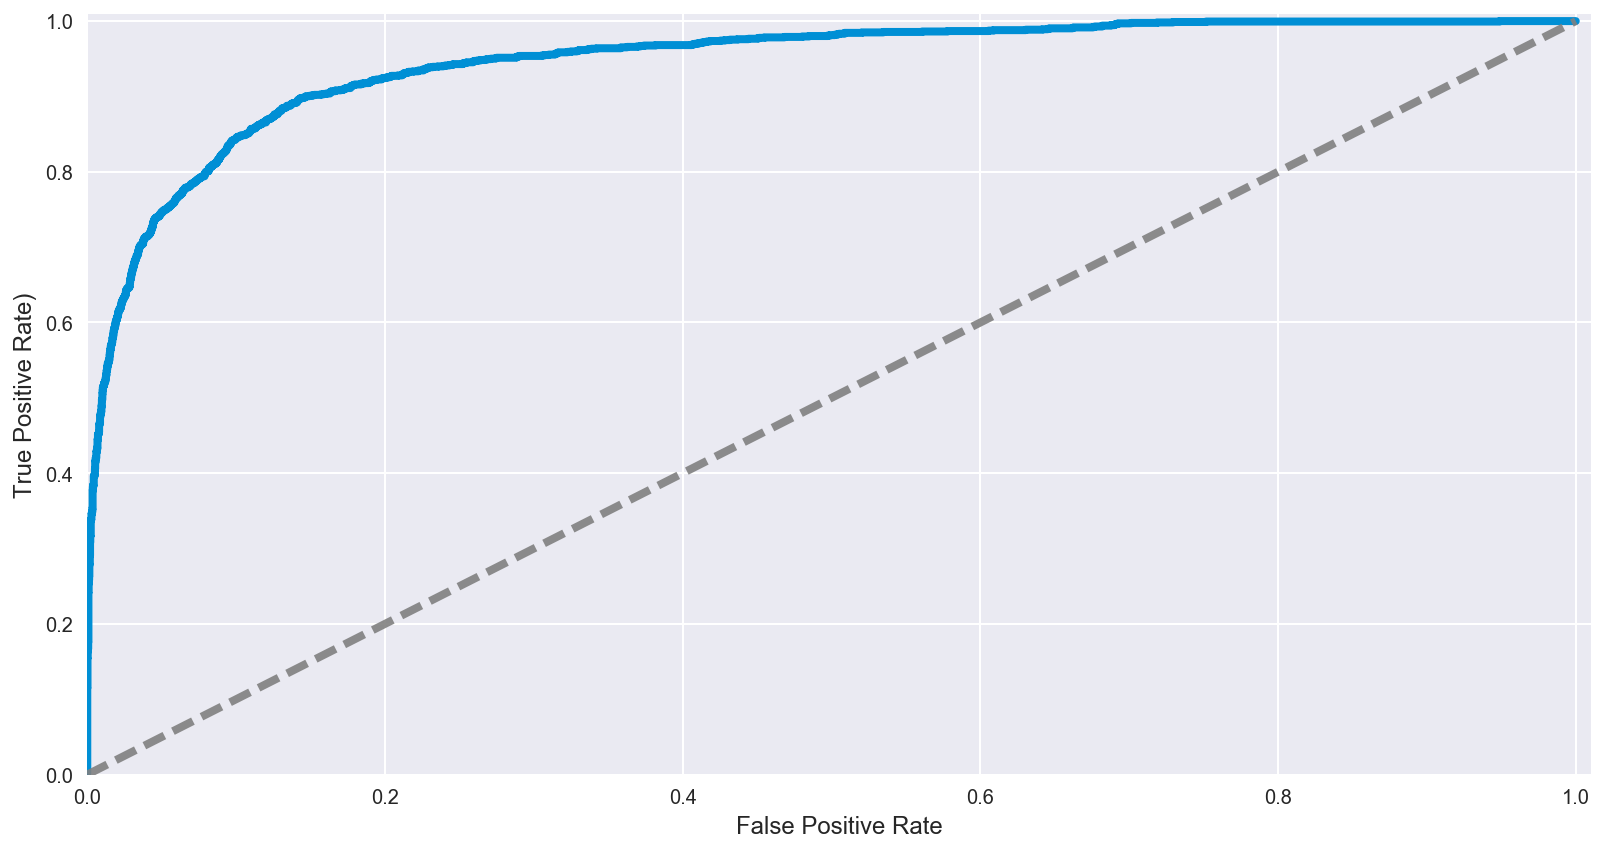

Baseline = 0.7939101373932297
auc = 0.944431428622


In [65]:
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7) #set up train/test/split as 70/30

estimator = LogisticRegression() #instantiated a Logistic Regression object
estimator.fit(X_train, y_train)

predicted = estimator.predict(X_test)

#Scoring accuracy of the model via 10 folds
from sklearn.cross_validation import cross_val_score
accuracy = cross_val_score(estimator, X_test, y_test, cv=10,scoring='accuracy')
print ('accuracy', accuracy, '\n')
print ('mean of scores =', np.mean(accuracy), '\n')

#Making Confusion Matrix
from nltk import ConfusionMatrix 
print ('ConfusionMatrix \n', ConfusionMatrix(list(y_test), list(predicted))) #Maybe y_test

# At what threshold, is this a false positive:
print ('Sensitivity \n', metrics.recall_score(y_test, predicted, pos_label=1)) #Maybe y_test

import matplotlib.pyplot as plt 
probs = estimator.predict_proba(X_test)[:, 1] 
plt.hist(probs) 
plt.show()

# check accuracy, sensitivity, specificity 
print ('accuracy score =', metrics.accuracy_score(y_test, predicted)) 

#ROC CURVES and AUC 
# plot ROC curve 
fig, ax = plt.subplots(figsize=(12,7))
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs, pos_label=1) 
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4)
plt.xlim([0.0, 1.01]) 
plt.ylim([0.0, 1.01]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate)') 
plt.show()

print('Baseline =', np.sum((y_test == 0)/ len(y_test)))

# calculate AUC 
print ('auc =',metrics.roc_auc_score(y_test, probs))

## Manually Calculating These Terms to Gain Better Understanding of Results

### Accuracy
The accuracy metric can be constructed using the components of the confusion matrix. With the total population as:

In [66]:
tp = np.sum((y_test == 1) & (predicted == 1))
fp = np.sum((y_test == 0) & (predicted == 1))
tn = np.sum((y_test == 0) & (predicted == 0))
fn = np.sum((y_test == 1) & (predicted == 0))
print(tn, fp, fn, tp)

6378 36 969 696


In [67]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predicted)

array([[6378,   36],
       [ 969,  696]])

In [68]:
total_population = tp + fp + tn + fn
print(total_population)

8079


In [69]:
#The proportion of correct guesses, regardless of the class
accuracy = (tp + tn) / total_population
print(round(accuracy,3))

0.876


The inverse of the accuracy is known as the misclassification rate, which is calculated:

In [70]:
misclassification_rate = (fp + fn) / total_population
print(round(misclassification_rate,3))

0.124


### Sensitivity / Recall / True Positive Rate
The true positive rate is the percent of times when the label is 1 the model actually predicted 1. This is alternatively known as the Sensitivity or Recall

In [71]:
sensitivity = tp / (tp + fn)
print("sensitivity =", round(sensitivity,3))

sensitivity = 0.418


### False Positive Rate
Alternatively, the false positive rate measures the fraction of times the model predicts a 1 when the target class is actually a 0

In [72]:
fpr = fp / (tn + fp)
print("False Positive Rate =", round(fpr,3))

False Positive Rate = 0.006


### Specificity, or the True Negative Rate
The true negative rate measures the fraction of times the classifier predicted the class was 0 out of all the times the class was 0. It can be considered the sister metric to Sensitivity, which measures the same thing but for positives.

In [73]:
specificity = tn / (tn + fp)
print("Specificity =", round(specificity, 3))

Specificity = 0.994


### Precision, or Positive Predictive Value
The precision measures the fraction of times that the classifier guessed correctly when it was predicting the true (1) class.

In [74]:
precision = tp / (tp + fp)
print("Precision =", round(precision,3))

Precision = 0.951


### F1-score and the classification_report
sklearn contains a function classification_report in the metrics submodule that helps diagnose the effectiveness of your classifier. The report focuses on the precision, recall, and a metric known as the f1-score.

The f1-score is the harmonic mean of the precision and recall metrics. Blending the two is useful: precision measures how effectively the classifier performs when it is predicting a 1, whereas recall measures how many of the total 1 classes out of all the 1-labeled observations were predicted correctly.

By combining the two we have a measure of the classifiers ability to find the positive labeled observations as well as how permissive it is for identification errors on those labels.

In [75]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.87      0.99      0.93      6414
          1       0.95      0.42      0.58      1665

avg / total       0.89      0.88      0.86      8079



[[6378   36]
 [ 969  696]]


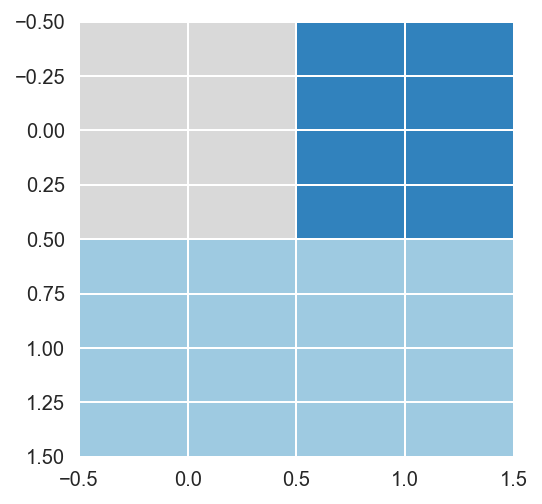

In [76]:
conf = confusion_matrix(y_test, predicted)
print(conf)

plt.imshow(conf,interpolation='None', cmap='Vega20c')
plt.show()

As you can see, my model classified the majority of tweets correctly. Translating this into a use case - If I send a report of 100 tweets over to a customer service rep, predicting false negatives over 10% is not a big deal since the customer service representative looking at these can easily filter those out. Ideally, I would like to fine tune my model to get the false positive number down as much as possible so unhappy customers can properly be addressed

# Customer Improvement Proposal

Wanted to save the most useful portion of the analysis for last. If I was to solve the main issue of how to improve overall customer satisfaction, I needed to examine the negative_reason column. Managers and stakeholders can use the graph below to allocate resources accordingly.

In [77]:
def rename_negreason_cat(x):
    if x == "Can't Tell":
        return "Unknown"
    elif x == 'longlines':
        return 'Long Line'
    elif x == 'Customer Service Issue':
        return 'Customer Service'
    else:
        return x

airline_tweets['negativereason'] = airline_tweets['negativereason'].map(rename_negreason_cat)

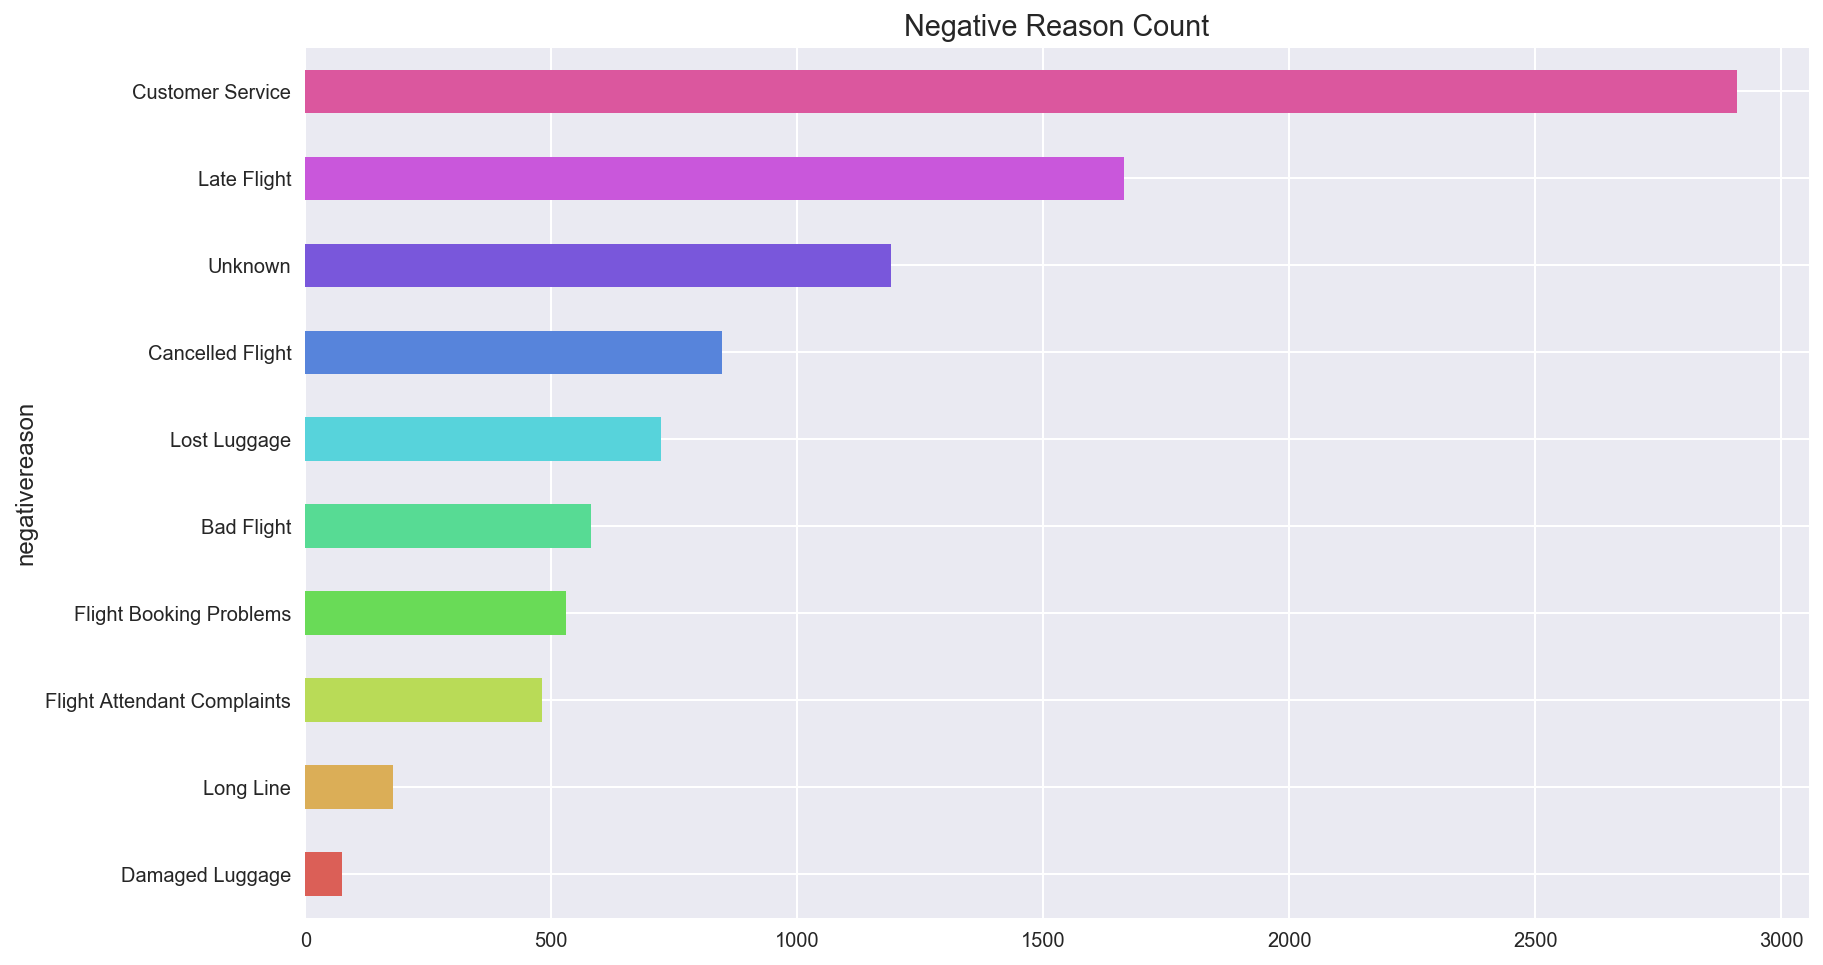

In [78]:
neg_reas_mask = airline_tweets['airline_sentiment'] == 'negative'
airline_tweets[neg_reas_mask].groupby('negativereason')['retweet_count'].count().sort_values().plot(kind="barh",figsize=(12,8), color=colors,
                                                                                                   title='Negative Reason Count')

Clearly, companies should be focusing on understanding their customers and how to improve overall customer service, as well as how they can improve the flight experience. Additionally, long lines can be dealt with by hiring more staff and booking problems can be addressed by holding the back end people accountable.

### Further Subsetting Negative Reason by Hour 
The hope is to find some trends regarding what time of day usually these mishaps occur.

In [79]:
pf = airline_tweets.groupby(['tweet_created_hour']).negativereason.value_counts()
pf.unstack()

negativereason,Bad Flight,Cancelled Flight,Customer Service,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Long Line,Lost Luggage,Unknown
tweet_created_hour,,,,,,,,,,
0,35.0,37.0,131.0,1.0,22.0,18.0,111.0,13.0,38.0,57.0
1,34.0,31.0,108.0,5.0,22.0,23.0,112.0,14.0,42.0,60.0
2,28.0,43.0,156.0,5.0,20.0,26.0,99.0,6.0,40.0,54.0
3,34.0,36.0,124.0,6.0,26.0,22.0,116.0,9.0,45.0,64.0
4,20.0,35.0,115.0,4.0,24.0,22.0,70.0,7.0,40.0,52.0
5,16.0,28.0,96.0,1.0,15.0,22.0,51.0,2.0,28.0,32.0
6,13.0,17.0,72.0,2.0,14.0,12.0,32.0,5.0,27.0,21.0
7,5.0,18.0,40.0,1.0,5.0,7.0,22.0,5.0,15.0,24.0
8,10.0,11.0,27.0,NaN,4.0,2.0,13.0,1.0,15.0,14.0


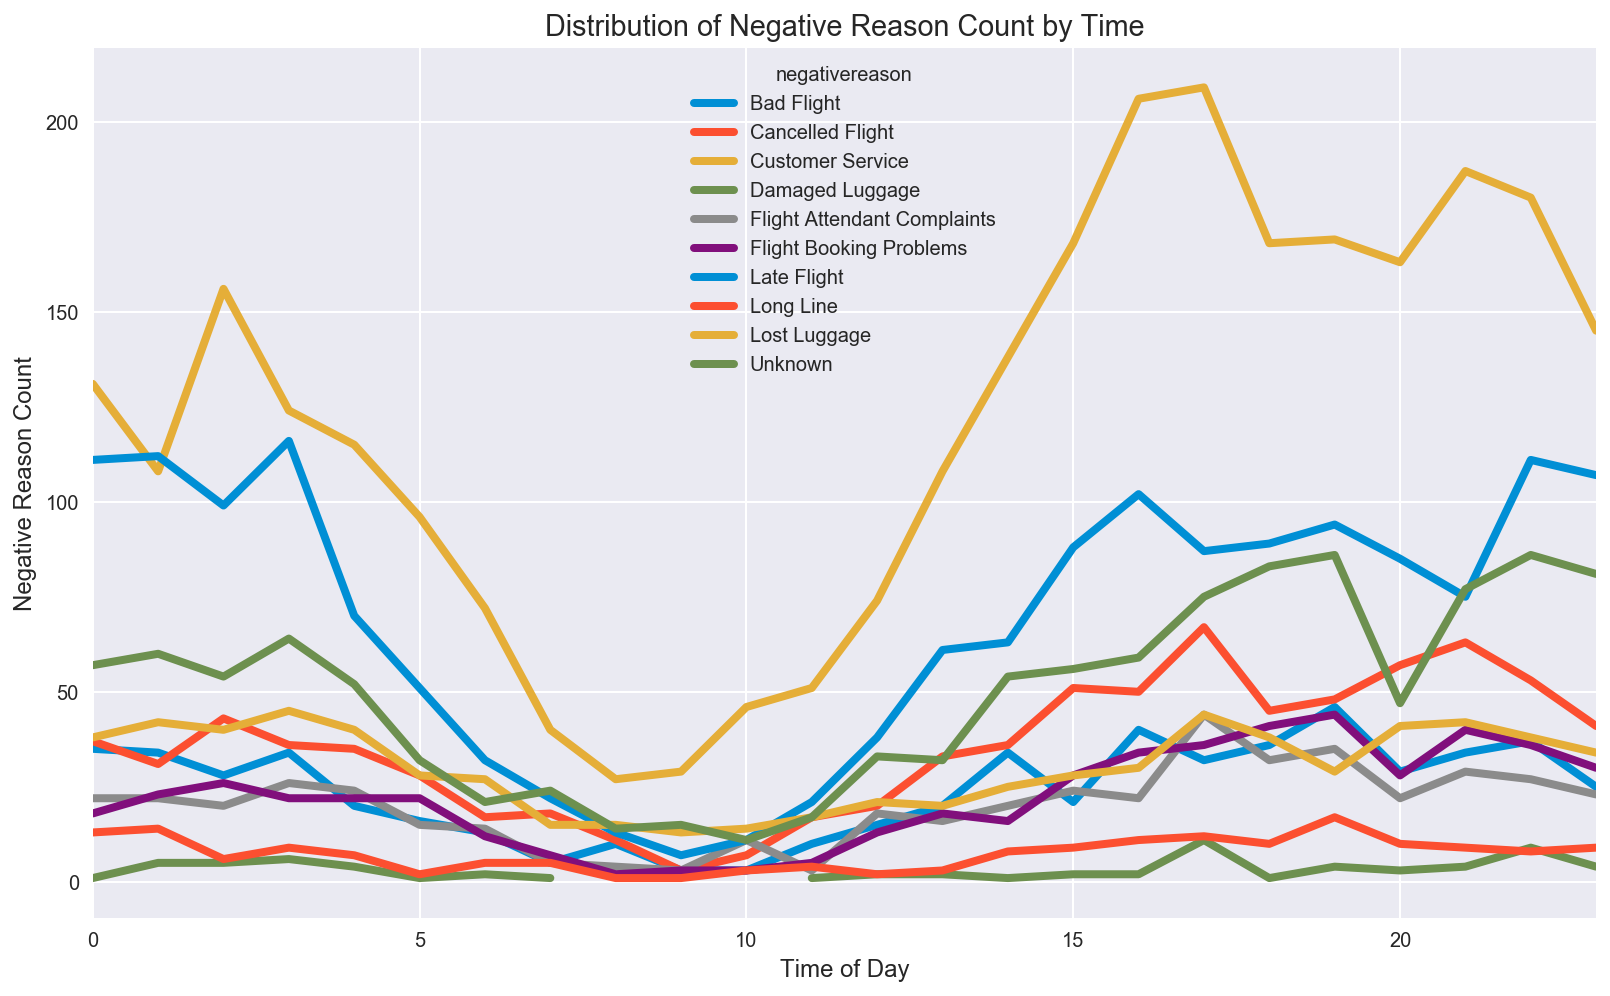

In [80]:
my_plot = pf.unstack().plot(kind='line',figsize=(12, 8),rot=0,title="Distribution of Negative Reason Count by Time")
my_plot.set_xlabel("Time of Day")
my_plot.set_ylabel("Negative Reason Count")

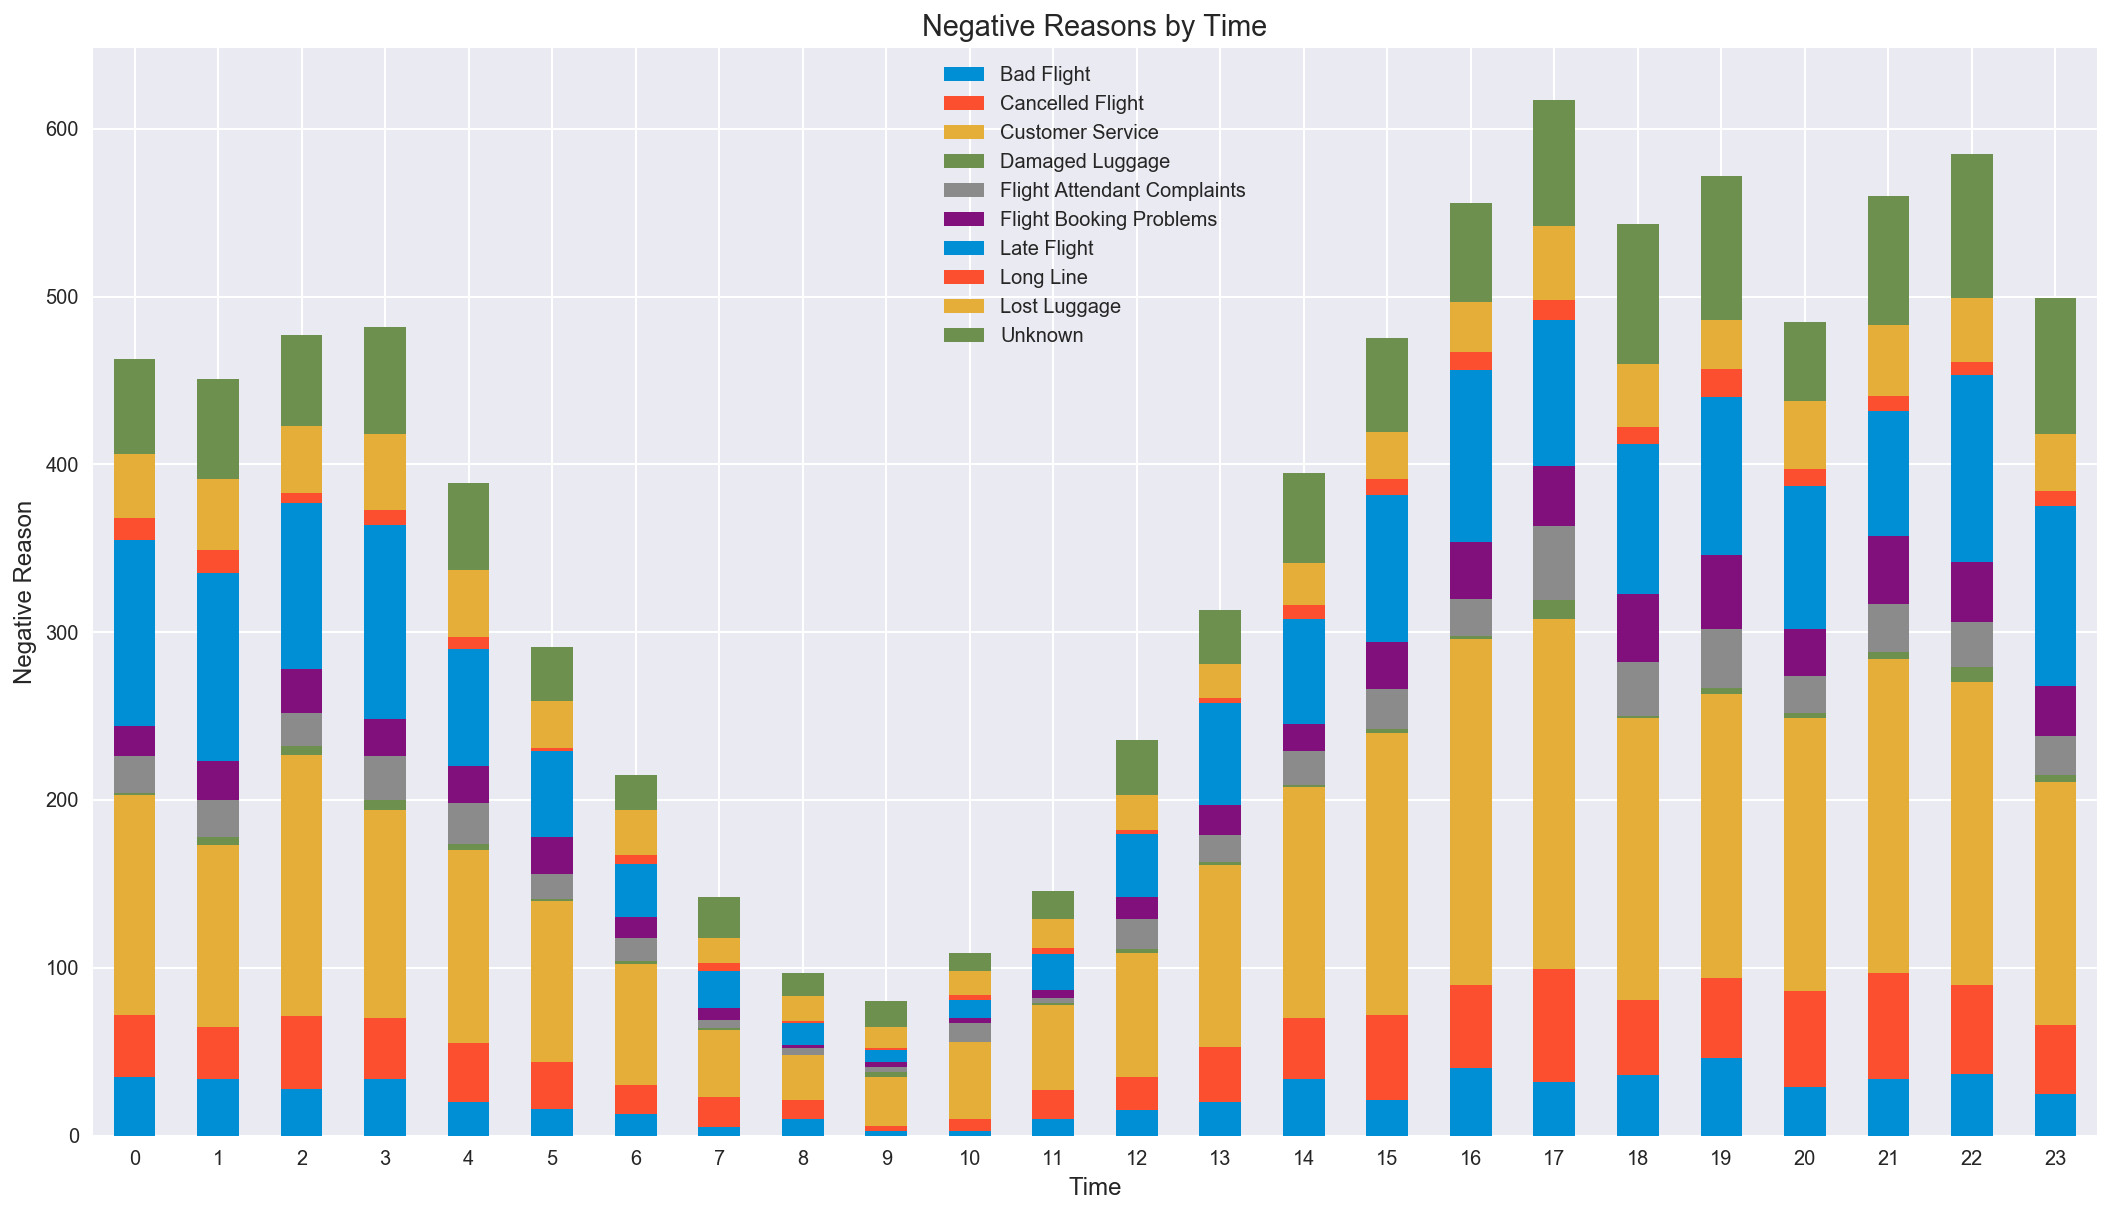

In [81]:
my_plot = pf.unstack().plot(kind='bar',stacked=True,figsize=(16, 10),rot=0,title="Negative Reasons by Time")
my_plot.set_xlabel("Time")
my_plot.set_ylabel("Negative Reason")
my_plot.legend(loc='best')

Both of the figures above tell the same story. Customer service issues are on a steep incline after 10:00 am. This may be because these are peek times for flying and more issues are likely to occur at this time. Subsetting by date and airline would allow me to pin-point exactly which airline is having the most problems on a particular day. This information could certainly be useful when a particular airline is looking to ramp up their customer service efforts.

## Next Steps:
* Integrate Twitter Streaming API to create real-time dashboards 
* Apply same pipeline to other sectors (hotels, rental cars, restaurants, etc.) The possibilities are endless!

A couple of next steps would be integrate the Twitter Streaming API to create real-time dashboards so stakeholders would be able to gauge customers’ sentiment on any given day. Another interesting problem to explore would be to apply the same pipeline of pulling tweets, classifying sentiment, and feature extraction to any industry or sector and see what customers are saying about

# Conclusion

* In niche markets, customer service may be the biggest differentiator when choosing one product/service versus another
* People are more likely to tweet with negative sentiment regarding a service, especially in the airline industry
* US Airways, American and United lead the way in tweets associated with negative sentiment proportionally
* Majority of tweets come from the East Coast, more specifically New York and D.C. This is probably because these cities are international hubs and many connecting flights go through here
* Peak hours of flying seem to be between 3PM to 3AM
* Airline companies should be allocating far more resources to their customer service department in order to communicate and listen more effectively. Issues such as late or cancelled flights are issues that may be out of any one party's control; however, all other complaints are able to be dealt with by paying attention to detail and allocating resources accordingly. For example, a better tracking system can be implemented to handle luggage in a more organized manner. Flight booking problems can be routed to the back-end people in charge of the flight booking infrastructure. And lastly, flight attendant complaints and long lines would be non-issues with the hiring of more staff during peak hours or flight attendants which are more suitable for the job (i.e. personable, patient, and pleasant)